In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from keras.metrics import Precision, Recall, AUC, CategoricalAccuracy
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

from custom_models.cnns import simple_cnn_bn
from etl.load_dataset import DatasetProcessor, get_tf_eggim_patch_dataset
from evaluation.metrics import categorical_accuracy, sensitivity_per_class, specificity_per_class

2024-08-17 16:31:57.140986: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 16:31:57.141072: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 16:31:57.141103: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 16:31:57.148735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_pivot_table(df, df_name='IPO+TOGAS'):
    pivot_table = pd.crosstab(df['landmark'], df['eggim_square'])
    # Plot the pivot table (crosstab) as a stacked bar plot
    pivot_table.plot(kind='bar', stacked=True)

    # Add labels and title
    plt.title(f'[{df_name}] Tally EGGIM scores by Landmark')
    plt.ylabel('Count')
    plt.xlabel('Landmark')

    # Show the plot
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_ordinal_distribution_side_by_side_with_colors(list_of_folds, df_name='IPO+TOGAS'):
    # Determine the number of folds and datasets per fold (assumed to be 3: train, val, test)
    num_folds = len(list_of_folds)

    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(nrows=num_folds, ncols=3, figsize=(18, 5 * num_folds))

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Titles for the columns
    titles = ['Train', 'Validation', 'Test']

    # Define a color map for the ordinal values (customize as needed)
    ordinal_colors = {0: 'skyblue', 1: 'lightgreen', 2: 'lightcoral', 3: 'orange', 4: 'purple'}

    # Loop through each fold
    for fold_idx, datasets in enumerate(list_of_folds):
        # datasets is a list containing [train, val, test] DataFrames for the current fold
        for dataset_idx, dataset in enumerate(datasets):
            # Get the current axis for plotting
            ax = axes[fold_idx * 3 + dataset_idx]

            # Get the value counts for the ordinal column
            counts = dataset['eggim_square'].value_counts().sort_index()

            # Get the colors for each bar based on the ordinal value
            bar_colors = [ordinal_colors[val] for val in counts.index]

            # Plot the distribution of the 'eggim_square' (ordinal variable) with custom colors
            counts.plot(kind='bar', ax=ax, color=bar_colors)

            # Set the title for the subplot
            ax.set_title(f'Fold {fold_idx + 1}: {titles[dataset_idx]}', fontsize=14)
            ax.set_ylabel('Count')
            ax.set_xlabel('EGGIM Score (Ordinal)')

    # Add a common title
    fig.suptitle(f'[{df_name}] Distribution of EGGIM Scores for 5-Fold CV', fontsize=16)

    # Adjust layout so titles and labels don't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust to fit the suptitle

    # Show the plot
    plt.show()

# Example usage:
# Suppose list_of_folds is a list of 5 elements, where each element is a list of 3 DataFrames: [train, val, test]
# list_of_folds = [[[train1], [val1], [test1]], [[train2], [val2], [test2]], ...]

# plot_ordinal_distribution_side_by_side_with_colors(list_of_folds)


In [4]:
def plot_pivot_table_side_by_side(list_of_folds, df_name='IPO+TOGAS'):
    # Determine the number of folds and datasets per fold (assumed to be 3: train, val, test)
    num_folds = len(list_of_folds)

    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(nrows=num_folds, ncols=3, figsize=(18, 5 * num_folds))

    # Flatten axes for easier indexing (in case of 1 row, axes won't be a 2D array)
    axes = axes.flatten()

    # Titles for the columns
    titles = ['Train', 'Validation', 'Test']

    # Loop through each fold
    for fold_idx, datasets in enumerate(list_of_folds):
        # datasets is a list containing [train, val, test] DataFrames for the current fold
        for dataset_idx, dataset in enumerate(datasets):
            # Get the current axis for plotting
            ax = axes[fold_idx * 3 + dataset_idx]

            # Create the pivot table
            pivot_table = pd.crosstab(dataset['landmark'], dataset['eggim_square'])

            # Plot the pivot table as a stacked bar plot
            pivot_table.plot(kind='bar', stacked=True, ax=ax, legend=True)

            # Set the title for the subplot
            ax.set_title(f'Fold {fold_idx + 1}: {titles[dataset_idx]}', fontsize=14)
            ax.set_ylabel('Count')
            ax.set_xlabel('Landmark')

    # Add a common title
    fig.suptitle(f'[{df_name}] Tally EGGIM scores by Landmark for 5-Fold CV', fontsize=16)

    # Adjust layout    so titles and labels don't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust to fit the suptitle

    # Show the plot
    plt.show()


In [5]:
target_dir = '../test_files/EGGIMazing/Dataset'
model_weights_directory = '../logs/crossvalidation/temp_splits/'

In [6]:
num_folds = 5
dp = DatasetProcessor(target_dir)
df = dp.process()
def replace_landmark_name(landmark):
    new_landmark_name = {'ii': 'distal body',
                    'ix': 'distal lc',
                    'vi': 'proximal ant lc',
                    'vii': 'proximal ant gc/pw',
                    'viii': 'incisura r',
                    'x': 'upper body r',
                    'xii': 'upper body ant'}
    landmark_number = landmark.split('.')[0]
    return new_landmark_name[landmark_number]
df['landmark'] = df['landmark'].apply(replace_landmark_name)
togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)

In [7]:
ipo_landmark_table = df.pivot_table(index='landmark', values='eggim_square', aggfunc=['count'])


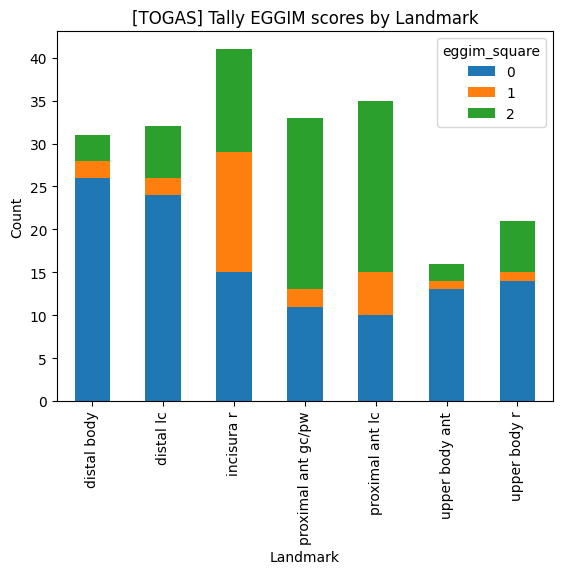

In [8]:
plot_pivot_table(df_togas, 'TOGAS')

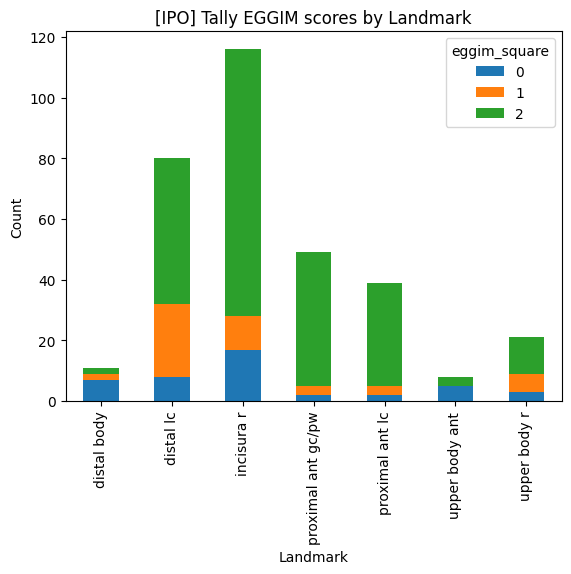

In [9]:
plot_pivot_table(df_ipo, 'IPO')

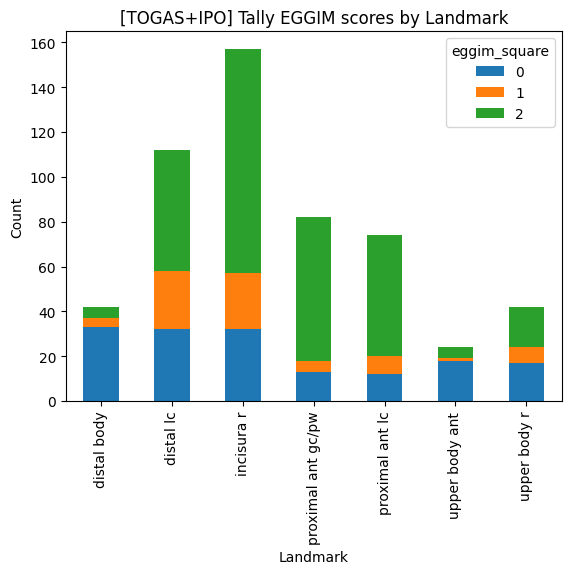

In [10]:
plot_pivot_table(pd.concat([df_togas, df_ipo], axis=0), 'TOGAS+IPO')

In [12]:
split_togas_only = dp.single_ds_group_k_splits(df_togas,
                                        k=num_folds,
                                        train_size=0.6,
                                        test_size=0.4,
                                        internal_train_size=0.5,
                                        random_state=42)

split_naive = dp.naive_multiple_ds_group_k_splits(df_togas,
                                      df_ipo,
                                      k=num_folds,
                                      train_size=0.6,
                                      test_size=0.4,
                                      internal_train_size=0.5,
                                      random_state=42)

split_smart = dp.smart_multiple_ds_group_k_splits(df_togas,
                                      df_ipo,
                                      k=num_folds,
                                      train_size=0.6,
                                      test_size=0.4,
                                      internal_train_size=0.5,
                                      random_state=42)
split_smarter = dp.smarter_multiple_ds_group_k_splits(df_togas,
                                      df_ipo,
                                      k=num_folds,
                                      train_size=0.6,
                                      test_size=0.4,
                                      internal_train_size=0.5,
                                      random_state=42)

split_smartest = dp.smarter_multiple_ds_group_k_splits(df_togas,
                                      df_ipo,
                                      k=num_folds,
                                      train_size=0.6,
                                      test_size=0.4,
                                      internal_train_size=0.5,
                                      random_state=42)

togas_only_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_togas_only]
naive_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_naive]
smart_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_smart]
smarter_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_smarter]
smartest_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_smartest]

In [13]:
togas_only_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_togas_only]
naive_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_naive]
smart_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_smart]
smarter_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_smarter]
smartest_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_smartest]

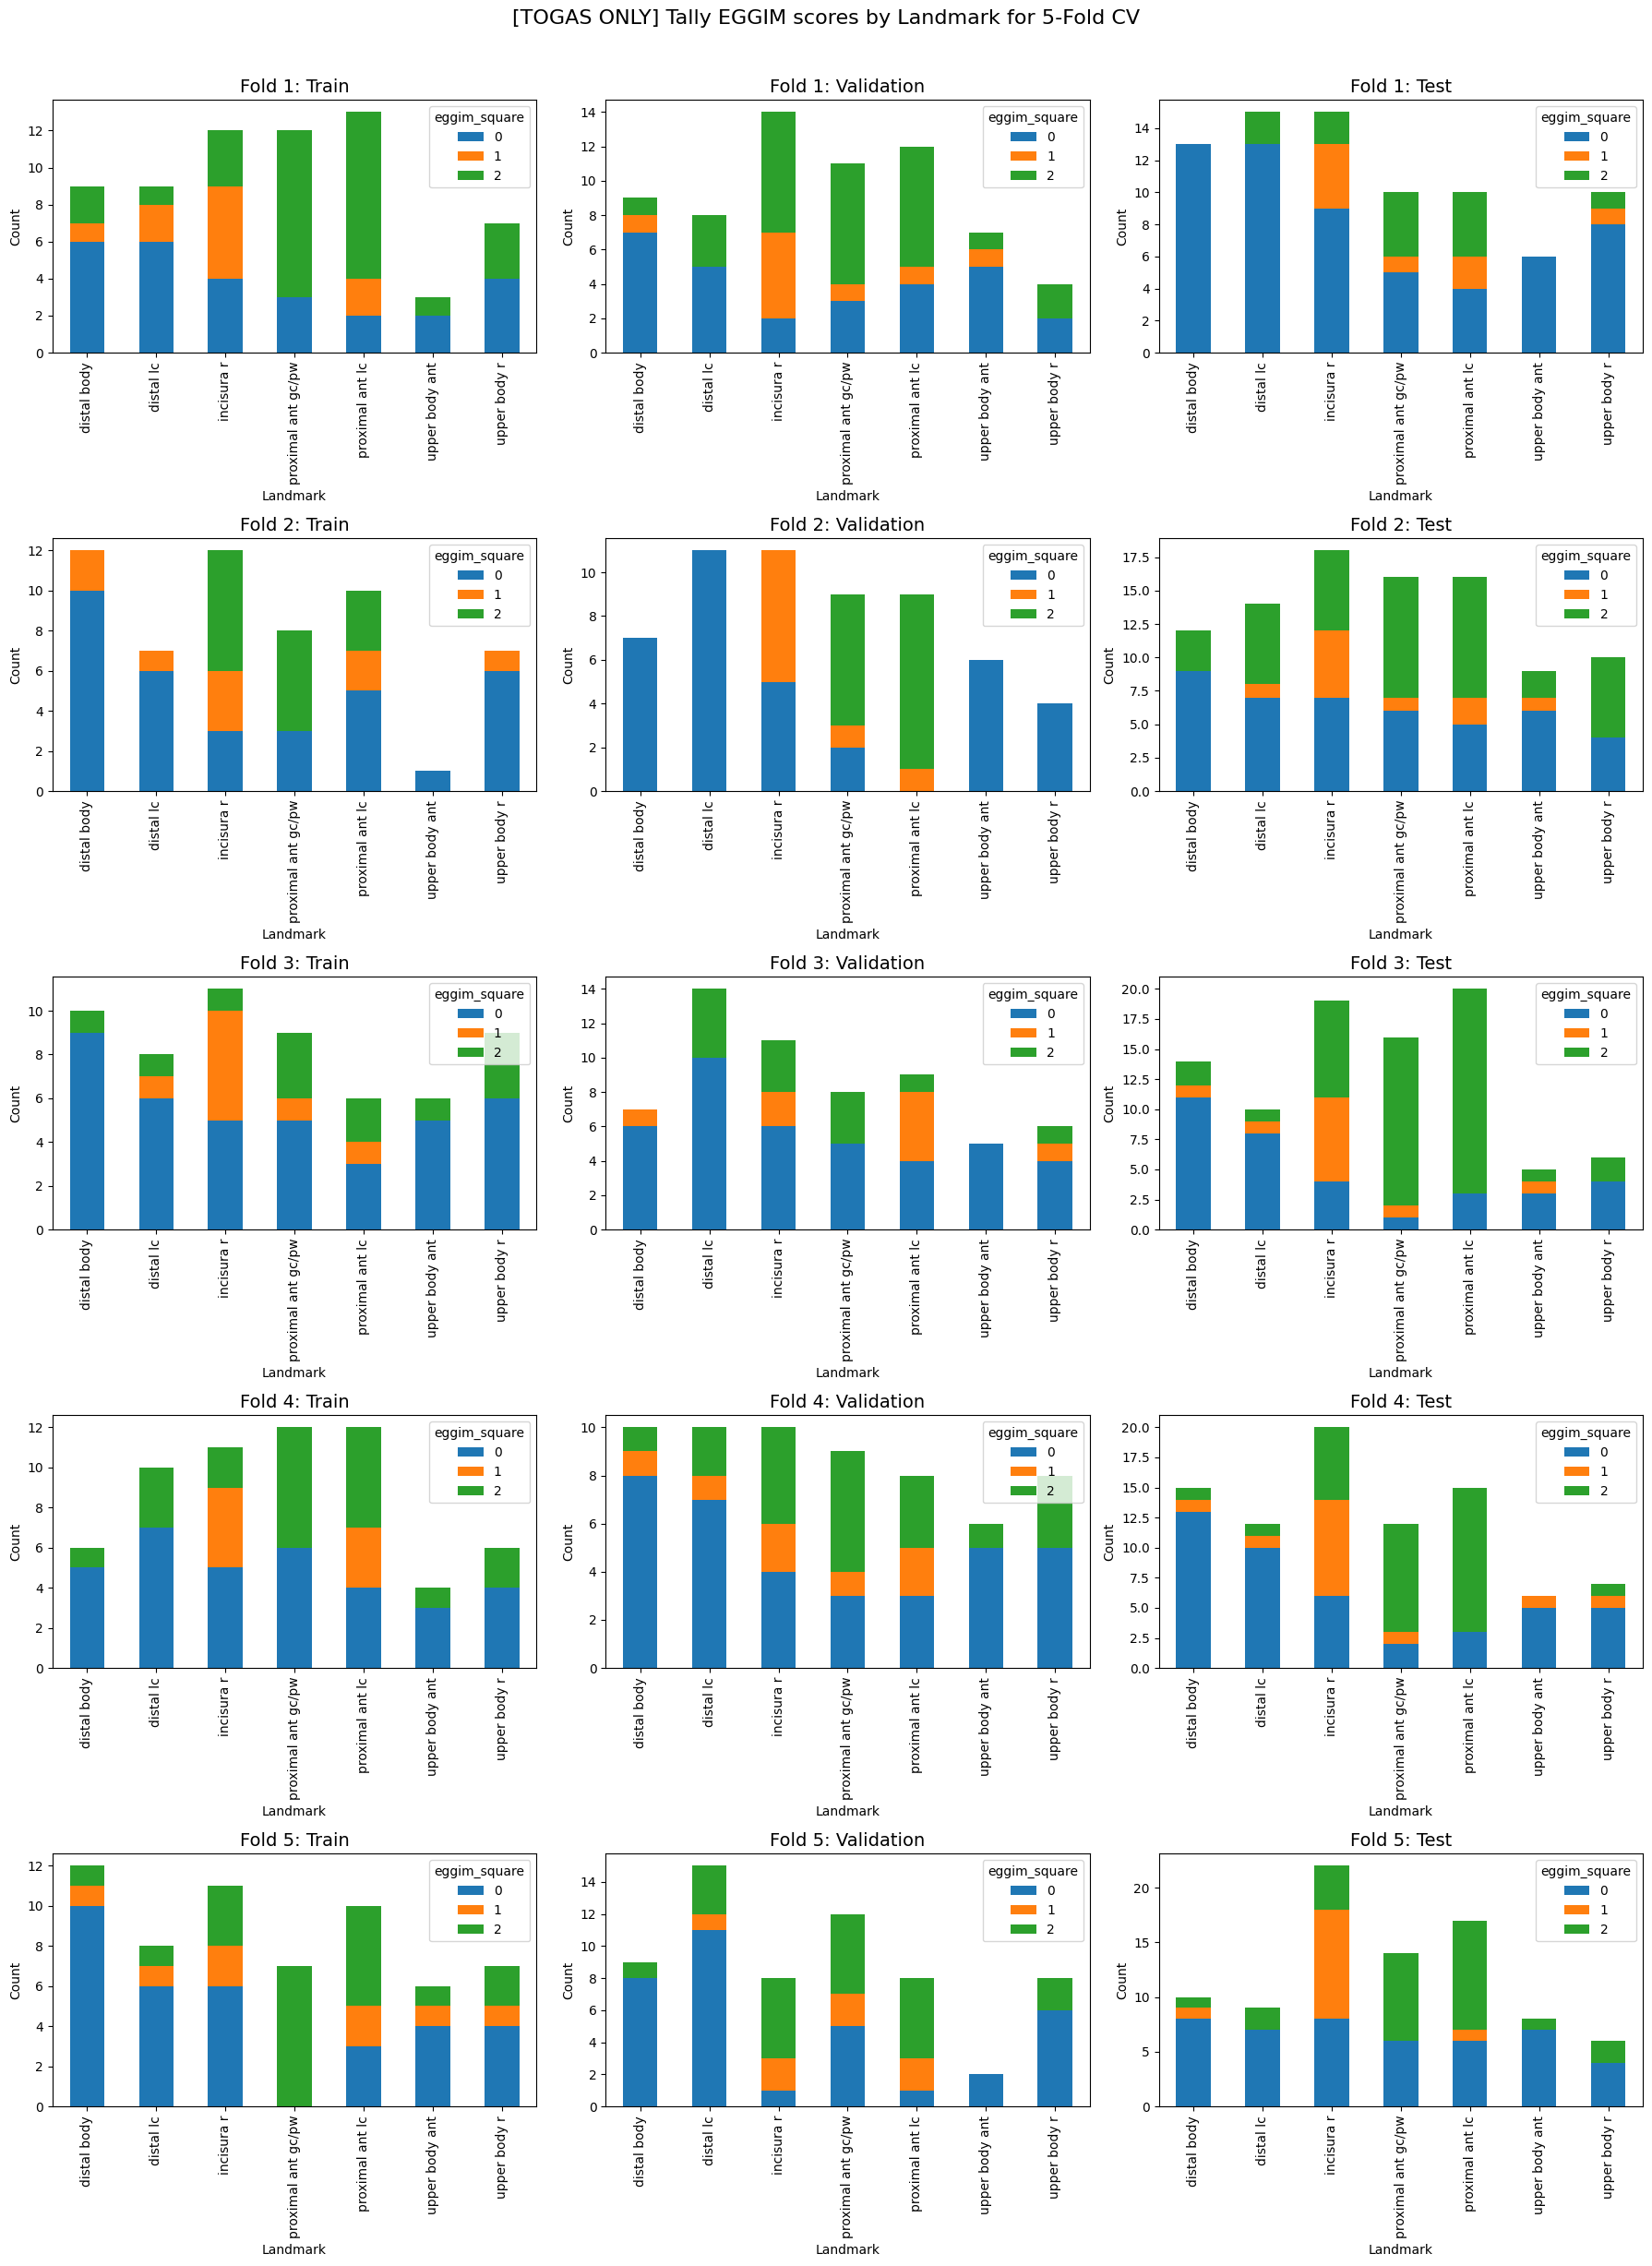

In [14]:
plot_pivot_table_side_by_side(togas_only_splits, 'TOGAS ONLY')

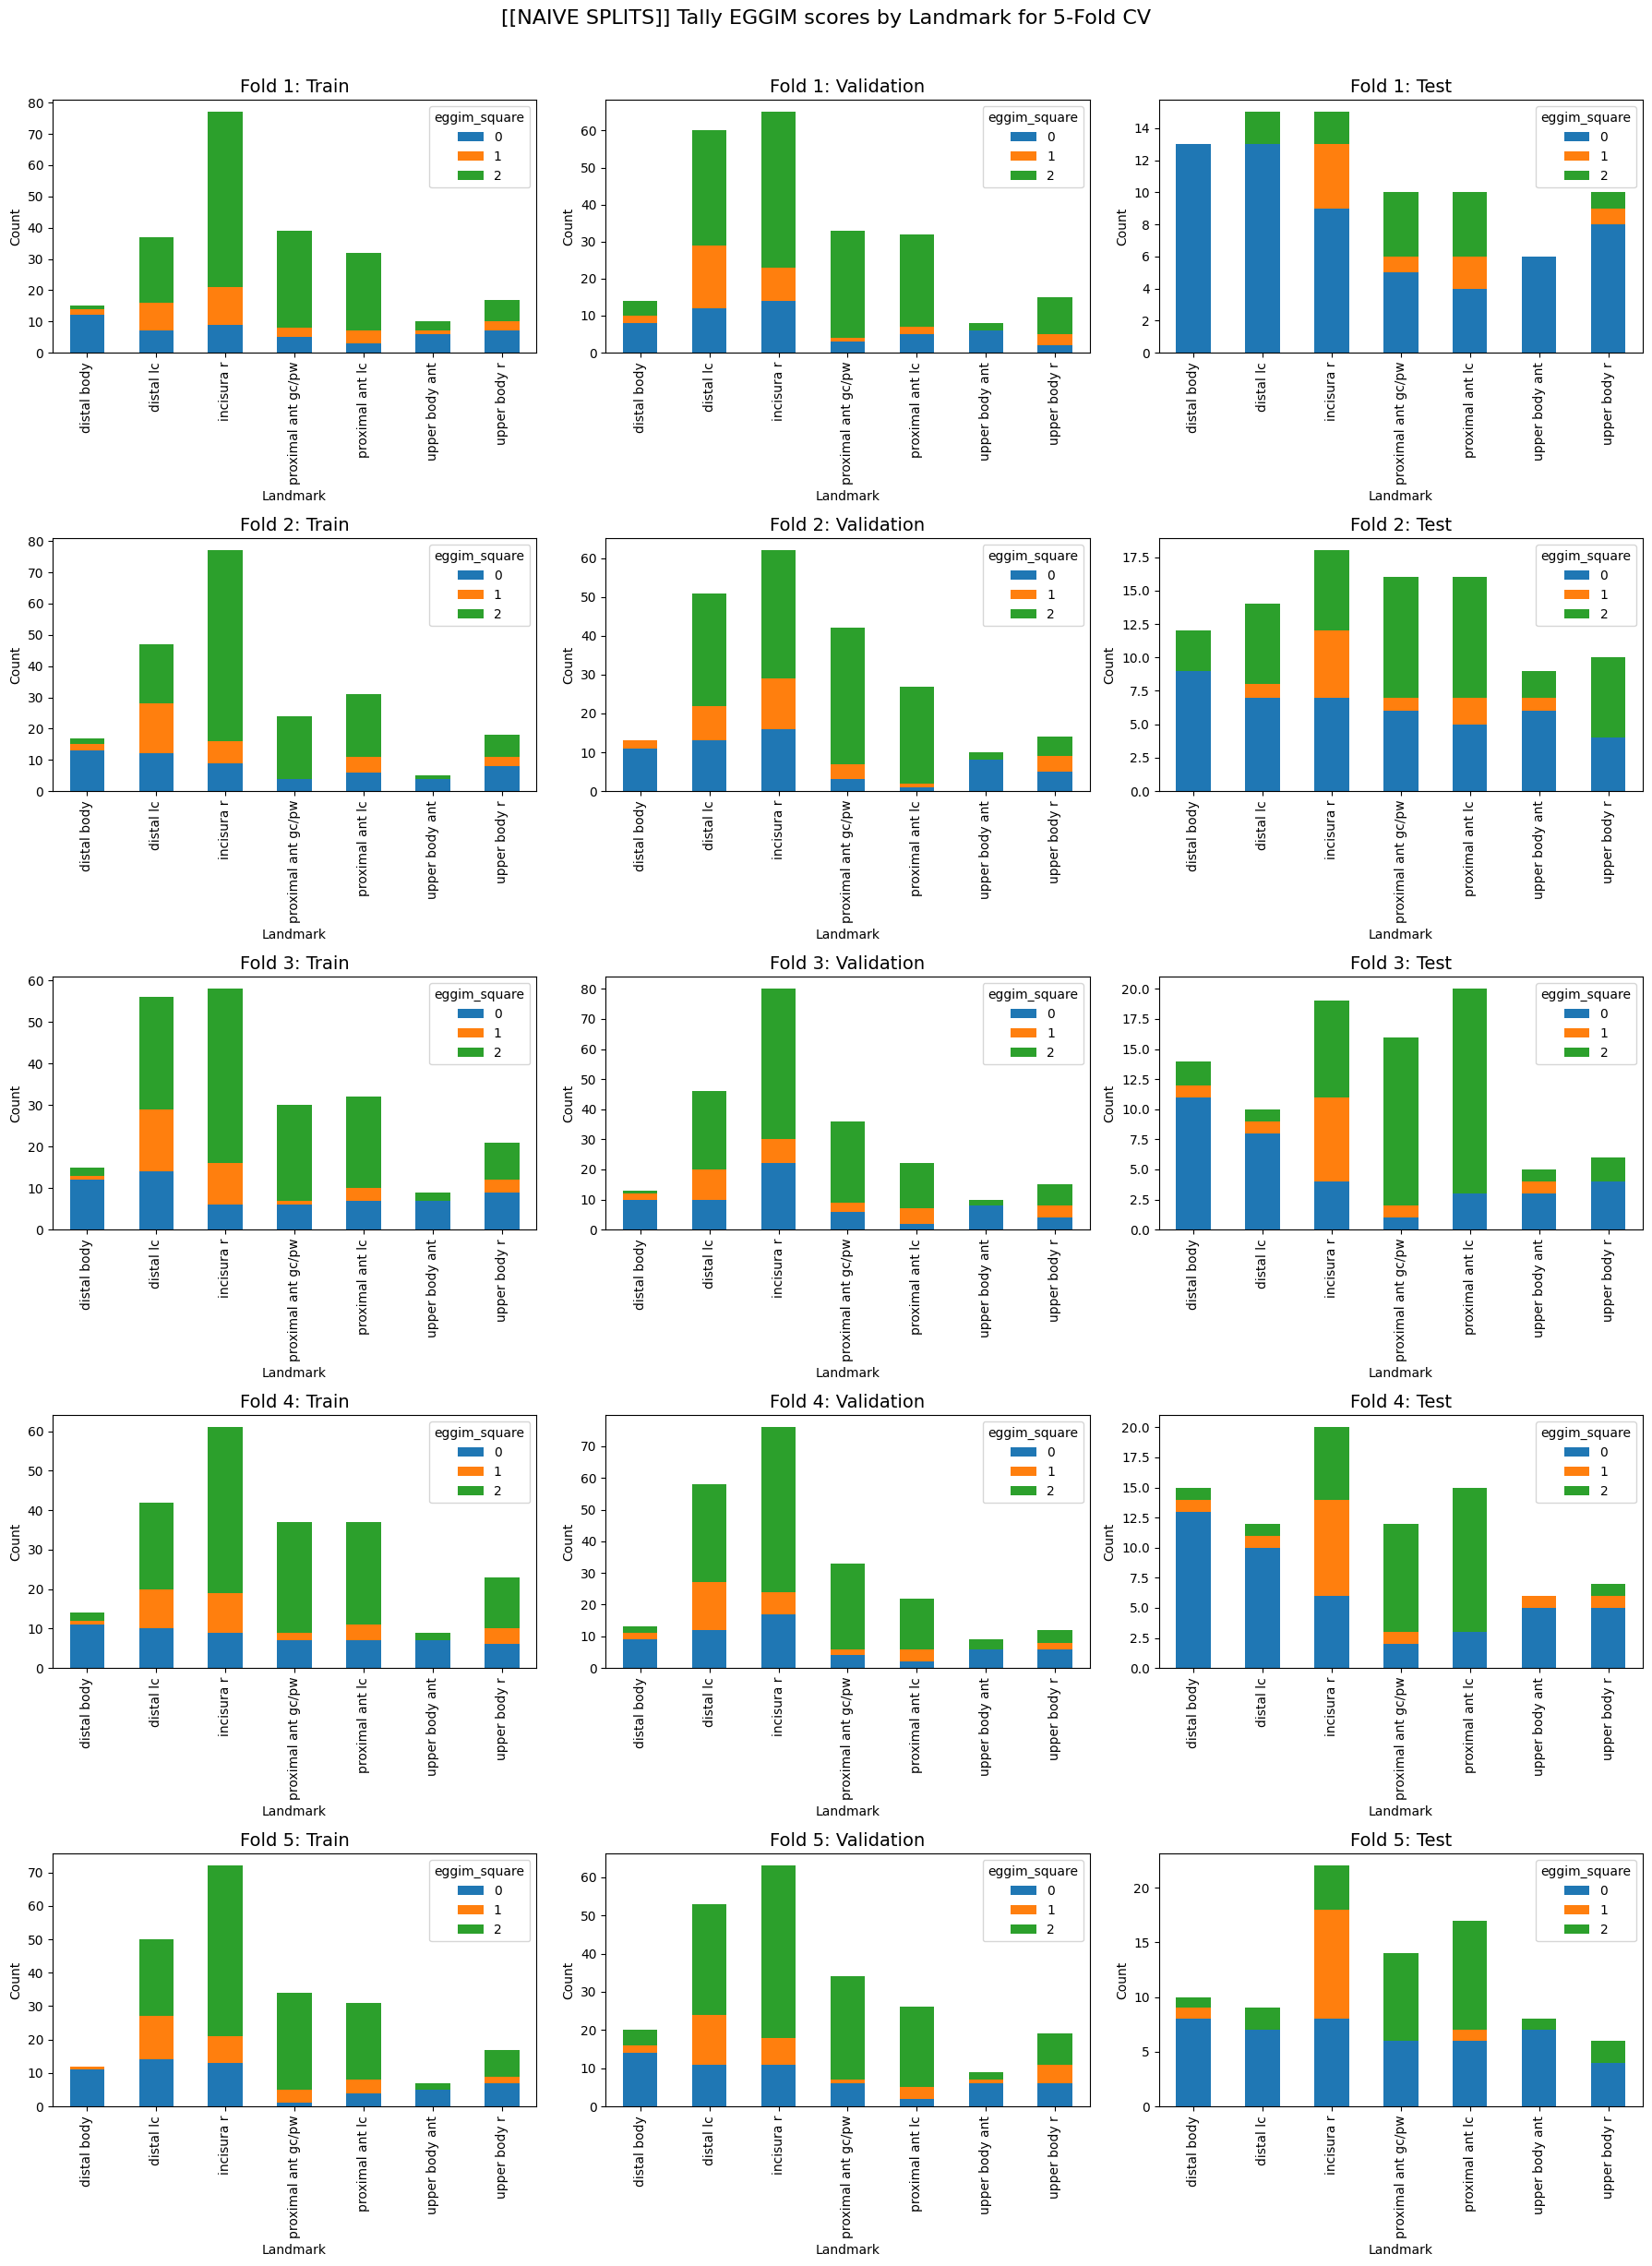

In [15]:
plot_pivot_table_side_by_side(naive_splits, '[NAIVE SPLITS]')

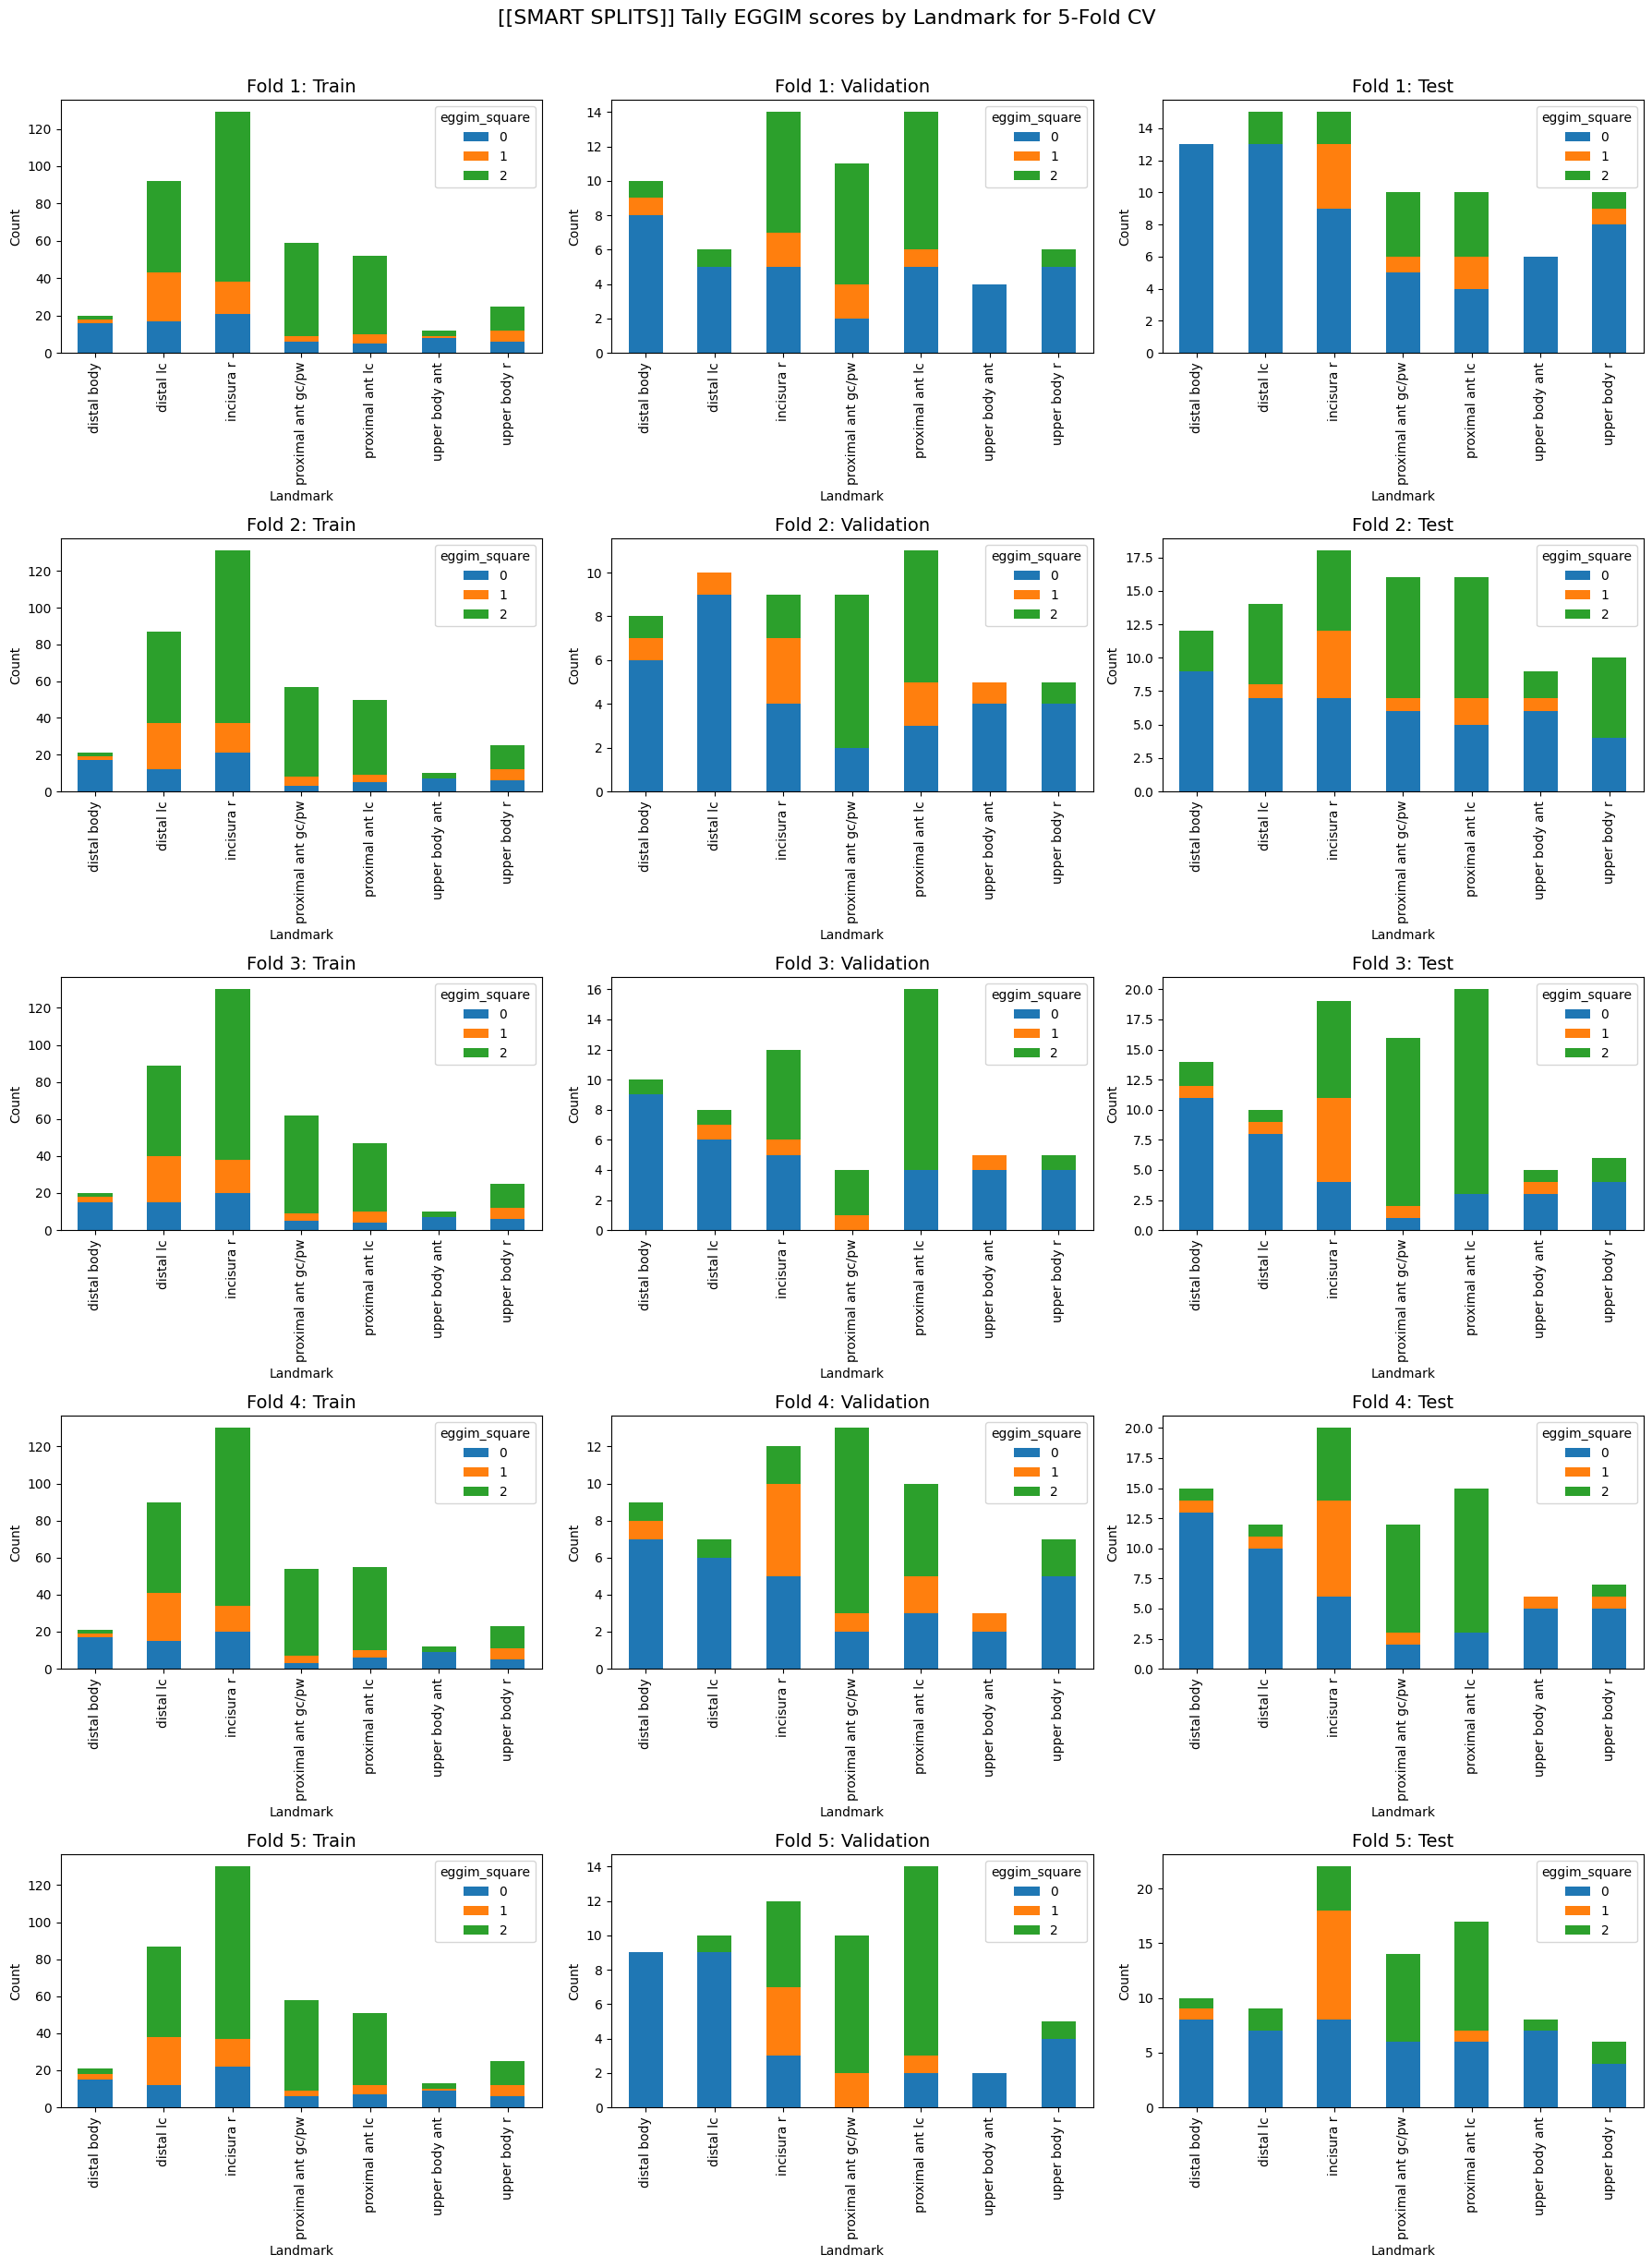

In [16]:
plot_pivot_table_side_by_side(smart_splits, '[SMART SPLITS]')

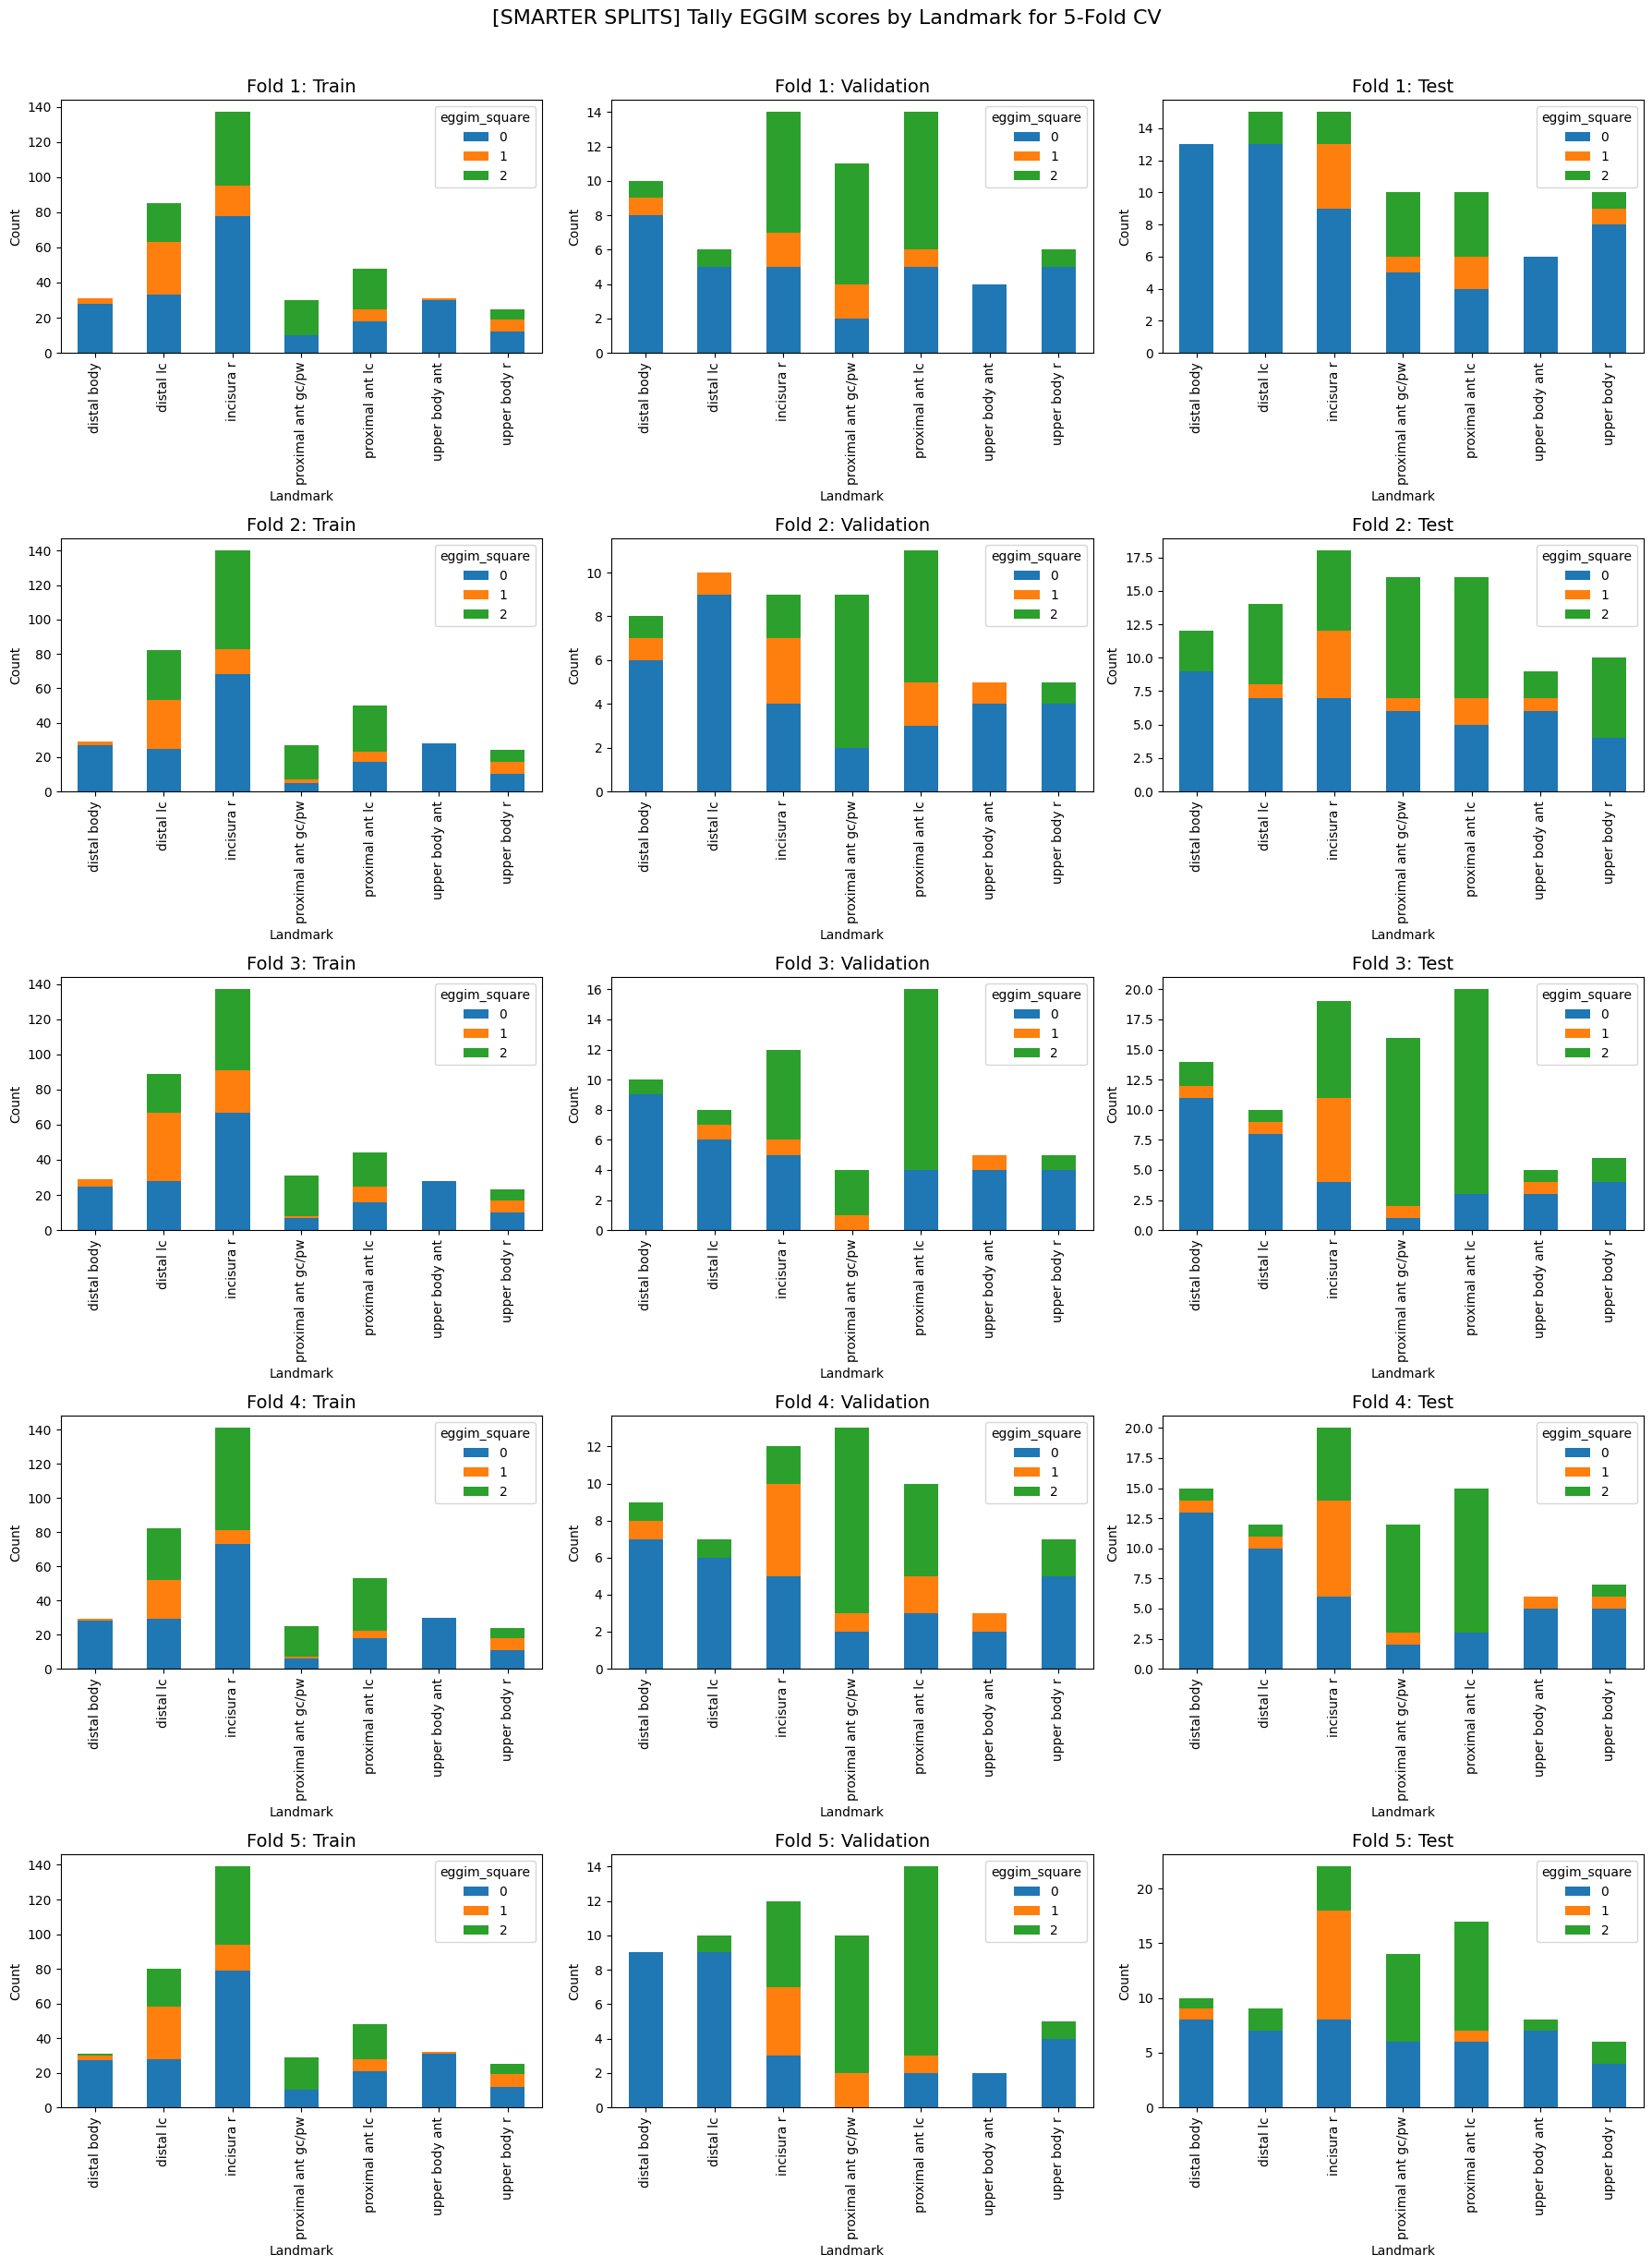

In [17]:
plot_pivot_table_side_by_side(smarter_splits, 'SMARTER SPLITS')

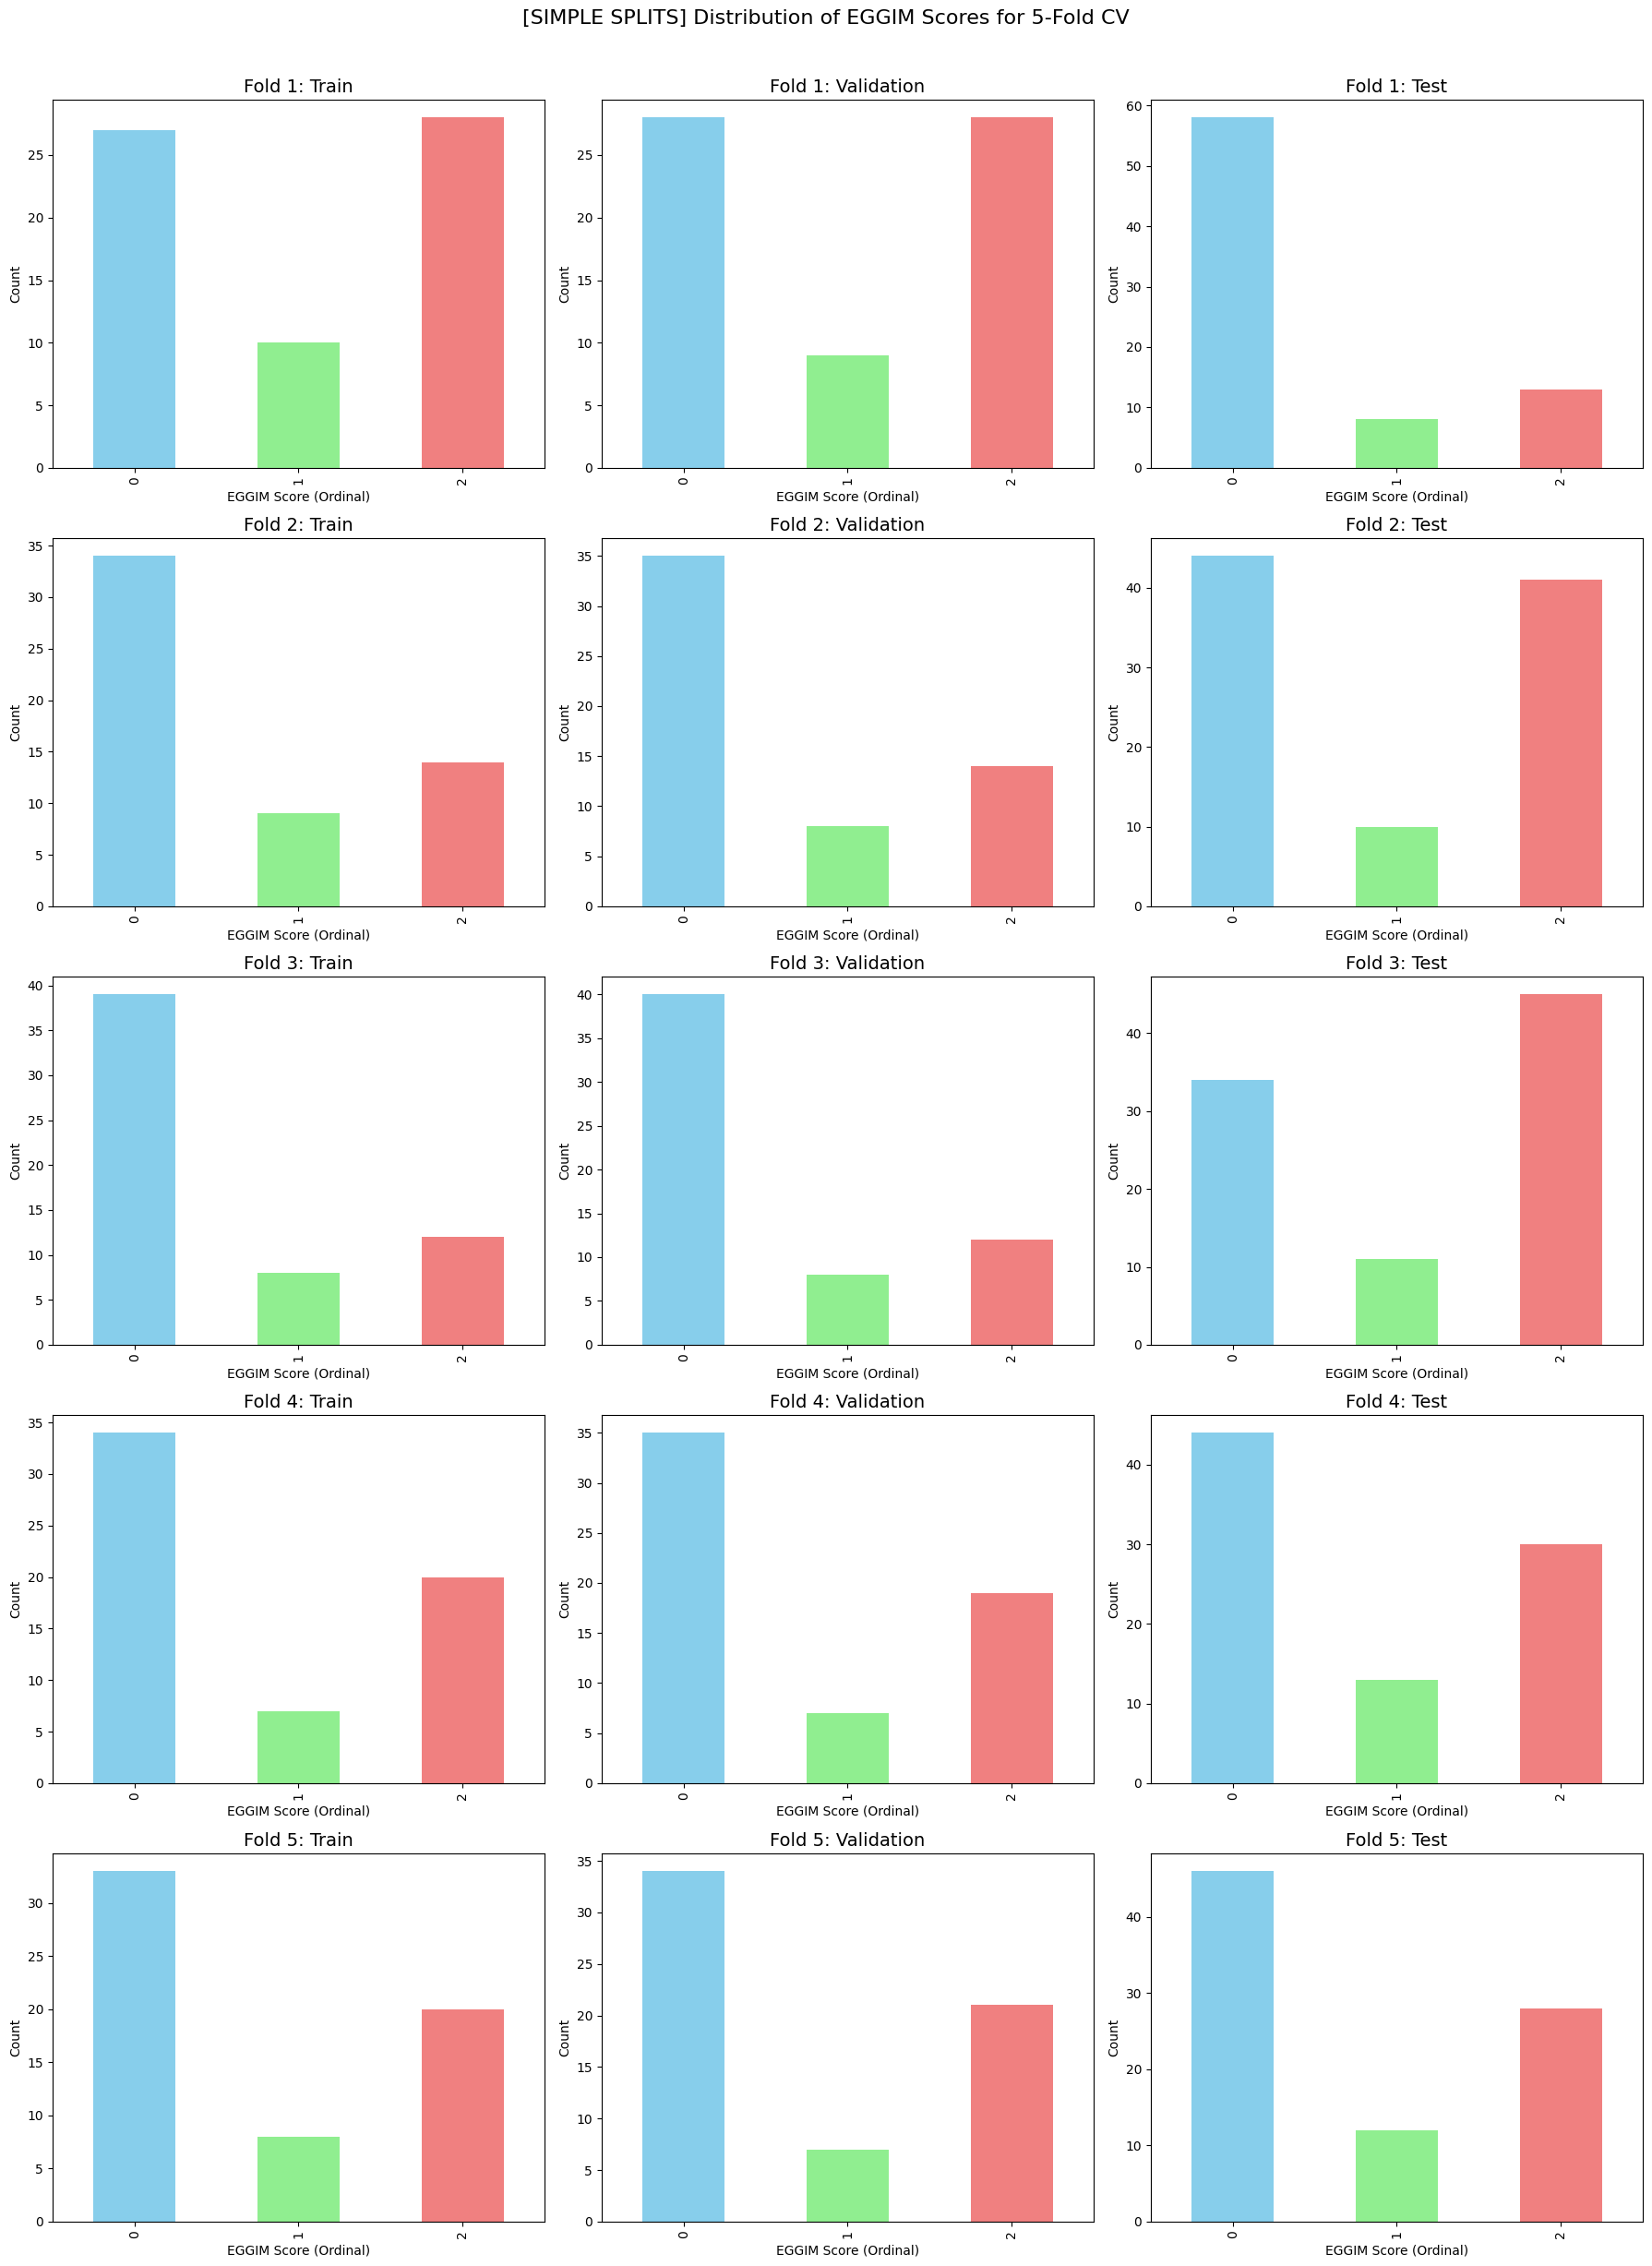

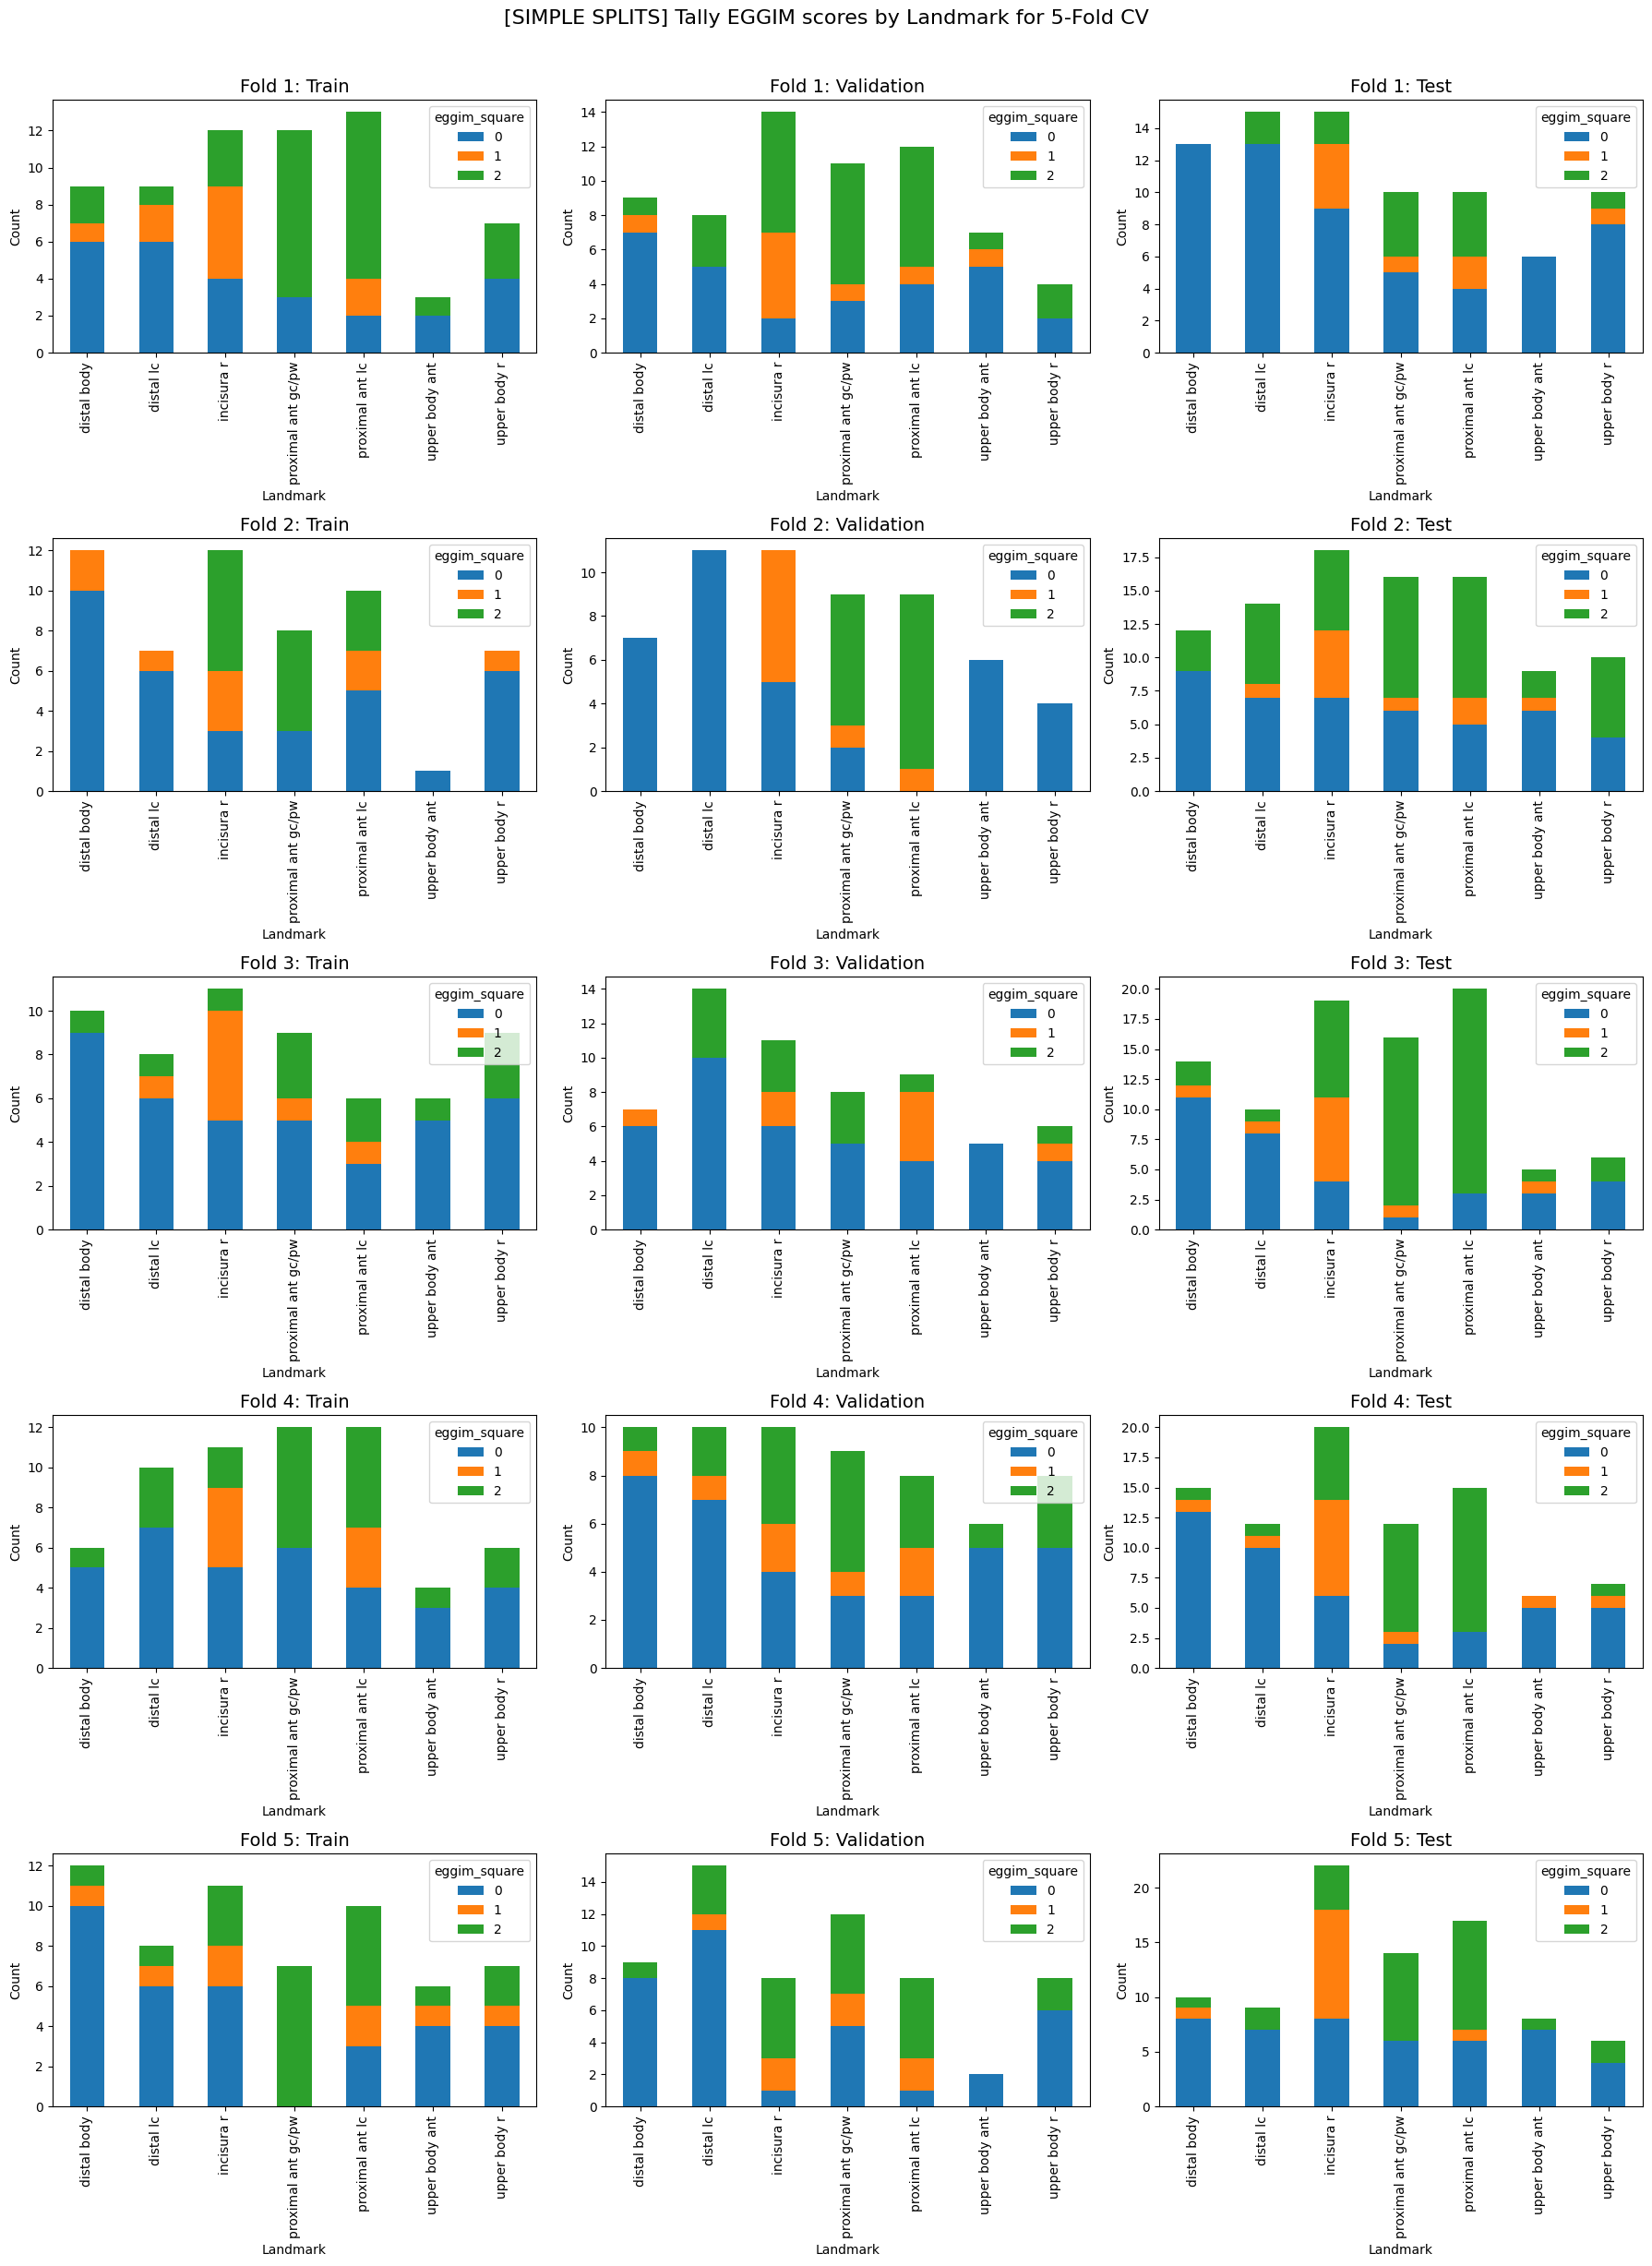

In [23]:
simple_split = dp.split = dp.single_ds_group_k_splits(df_togas, k=5, train_size=0.6,
                                                  test_size=0.4, random_state=42)
simple_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in simple_split]
plot_ordinal_distribution_side_by_side_with_colors(simple_splits, 'SIMPLE SPLITS')
plot_pivot_table_side_by_side(simple_splits, 'SIMPLE SPLITS')


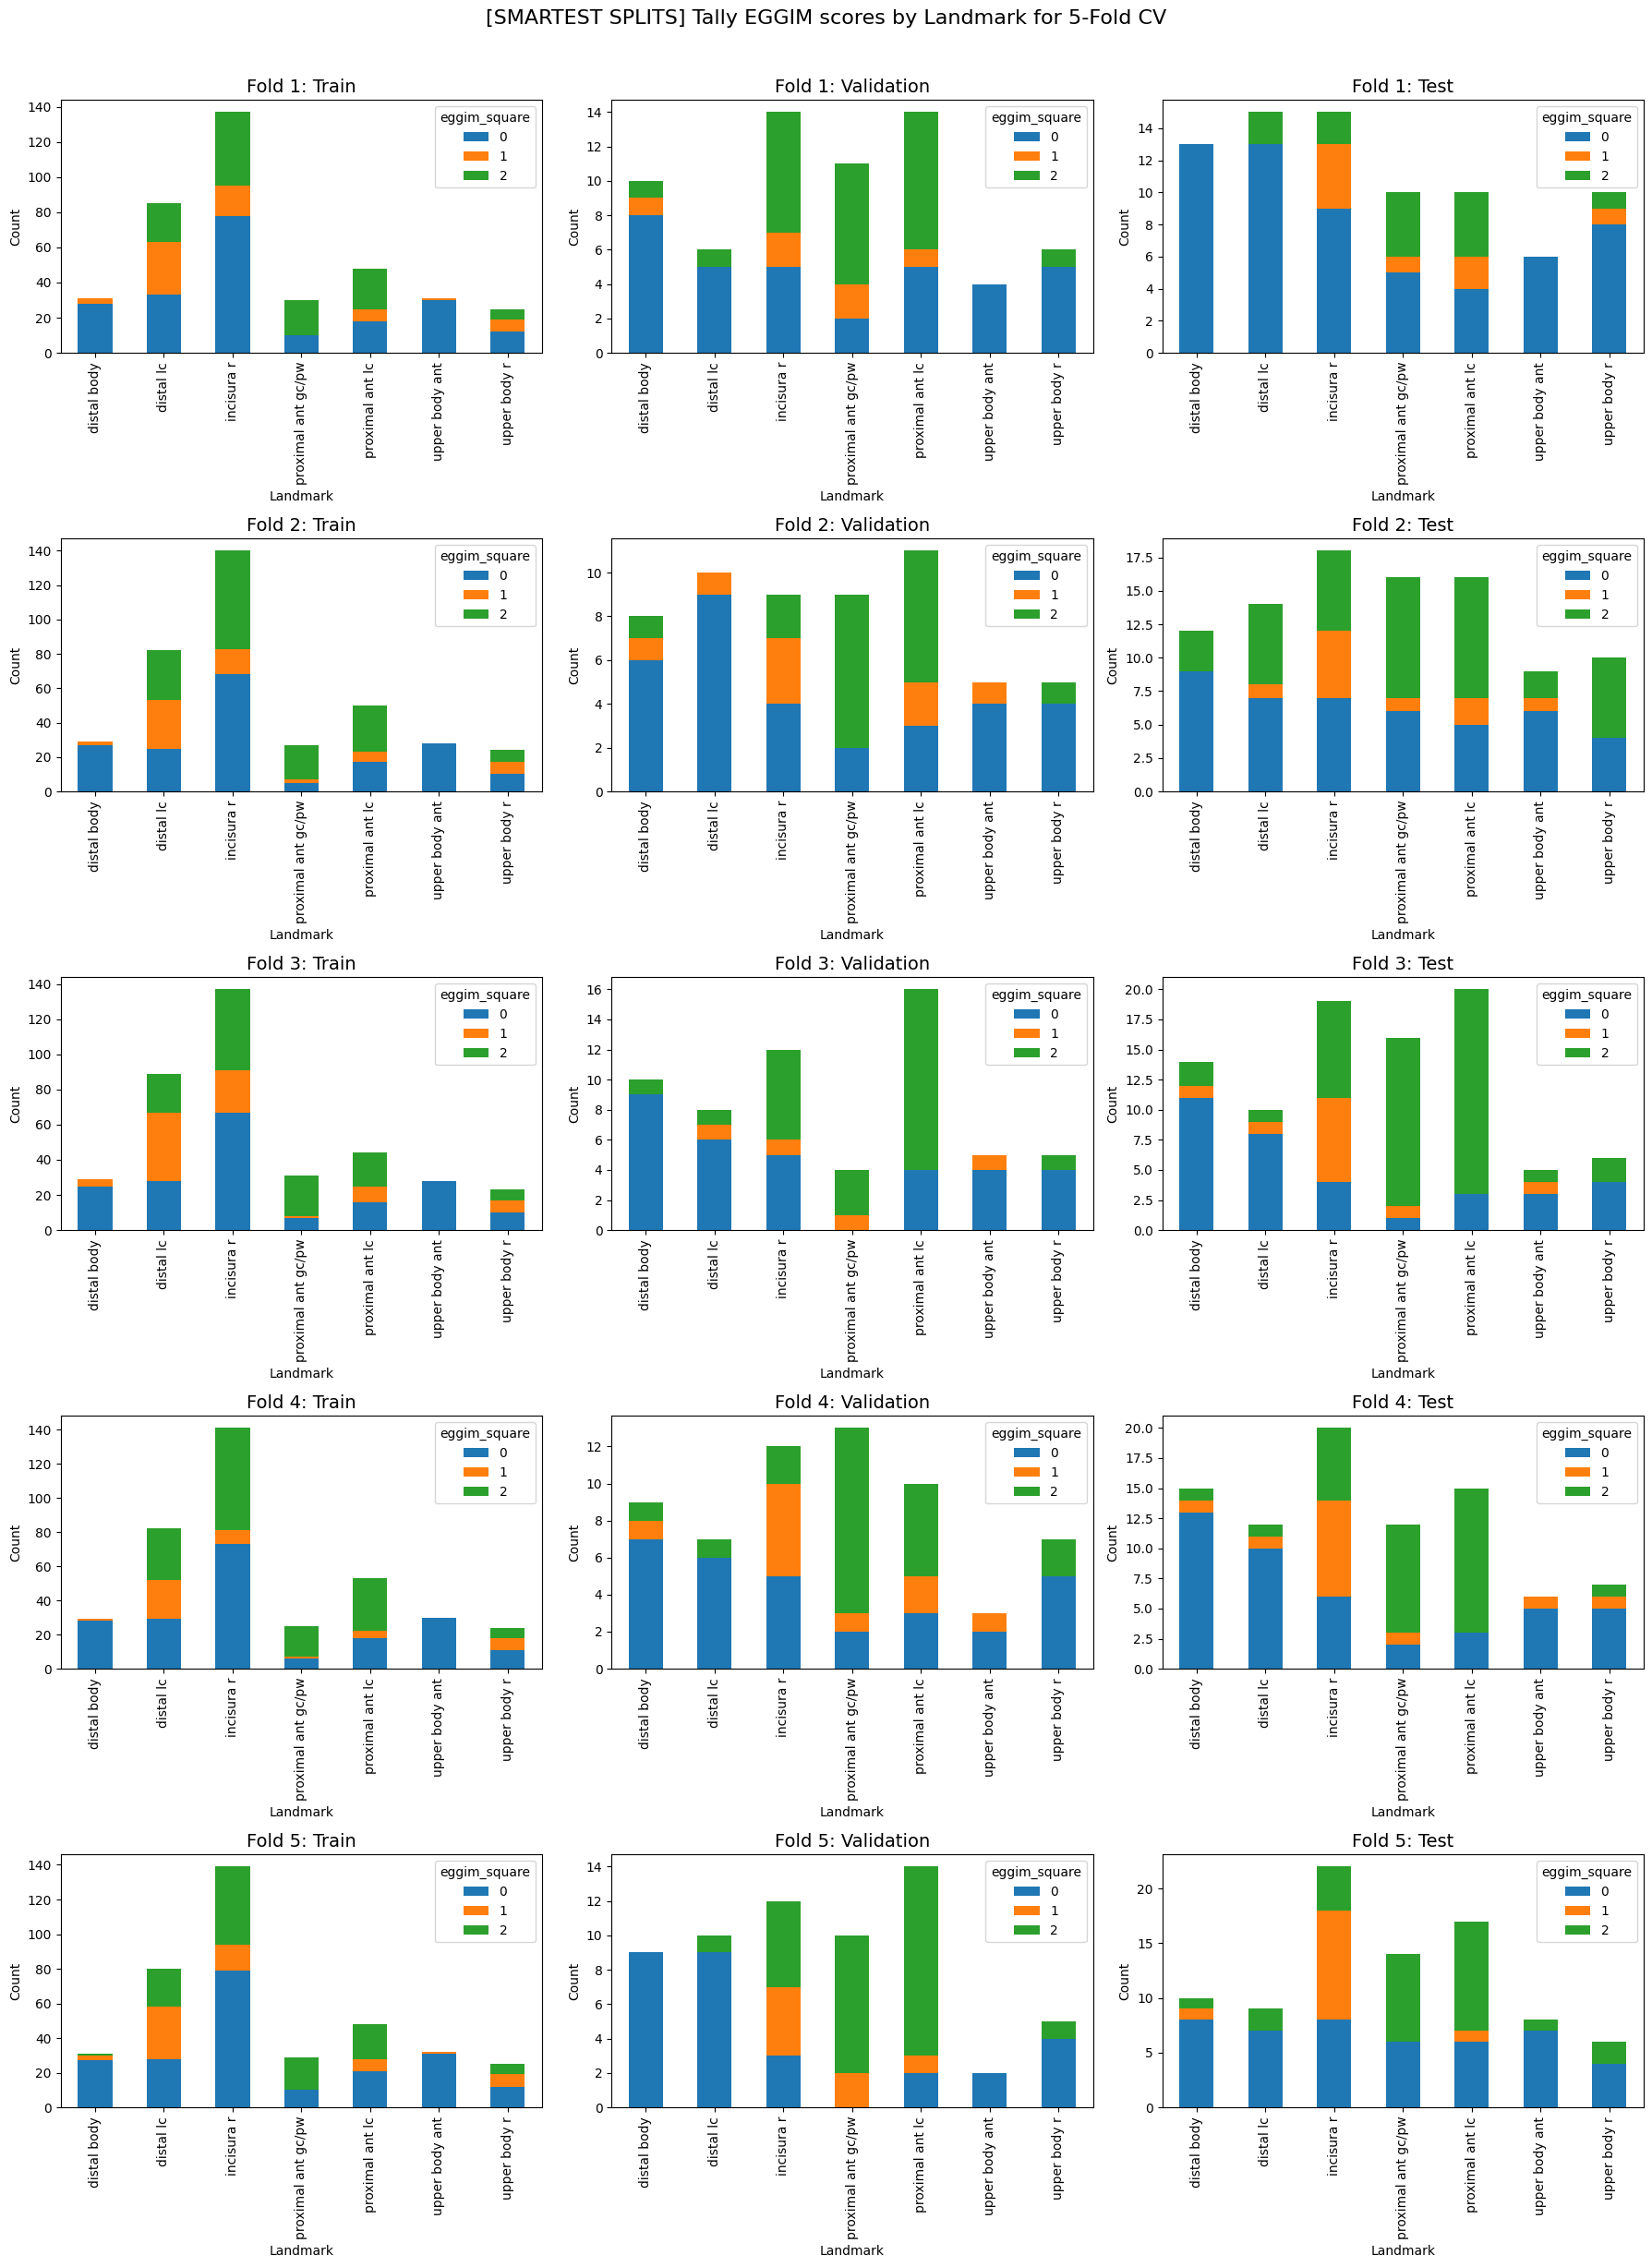

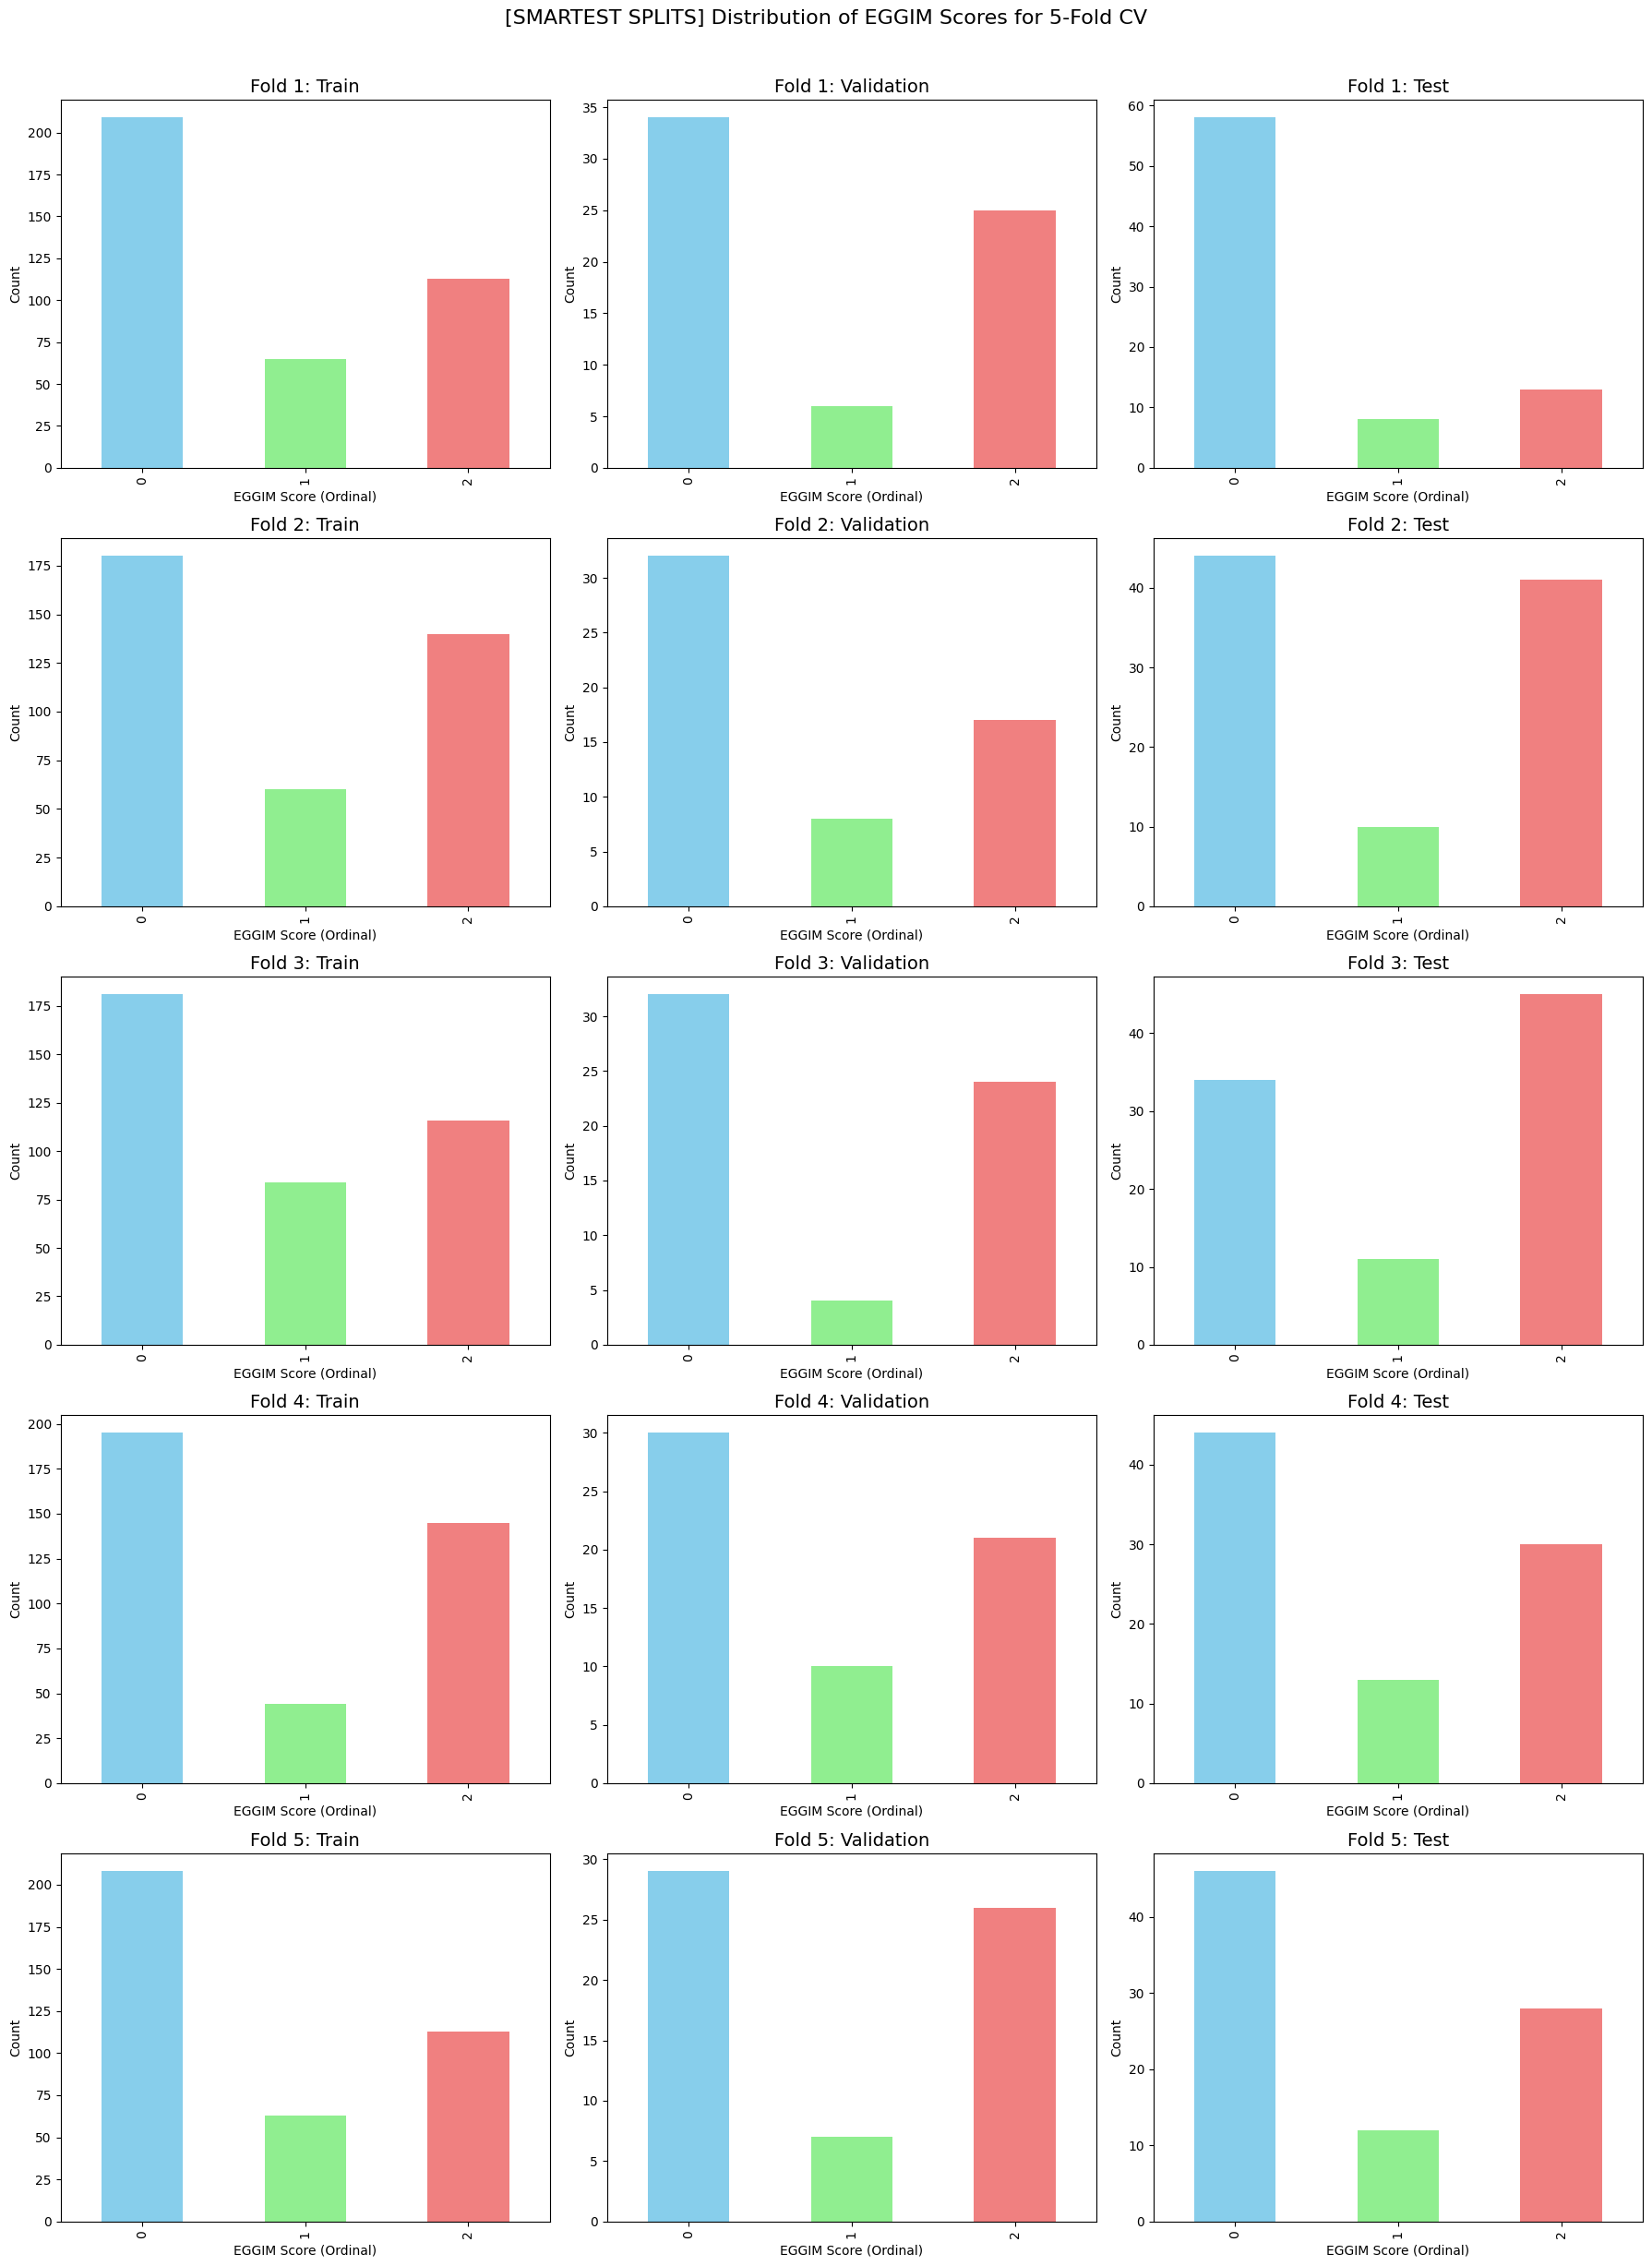

In [16]:
plot_pivot_table_side_by_side(smartest_splits, 'SMARTEST SPLITS')
plot_ordinal_distribution_side_by_side_with_colors(smartest_splits, 'SMARTEST SPLITS')

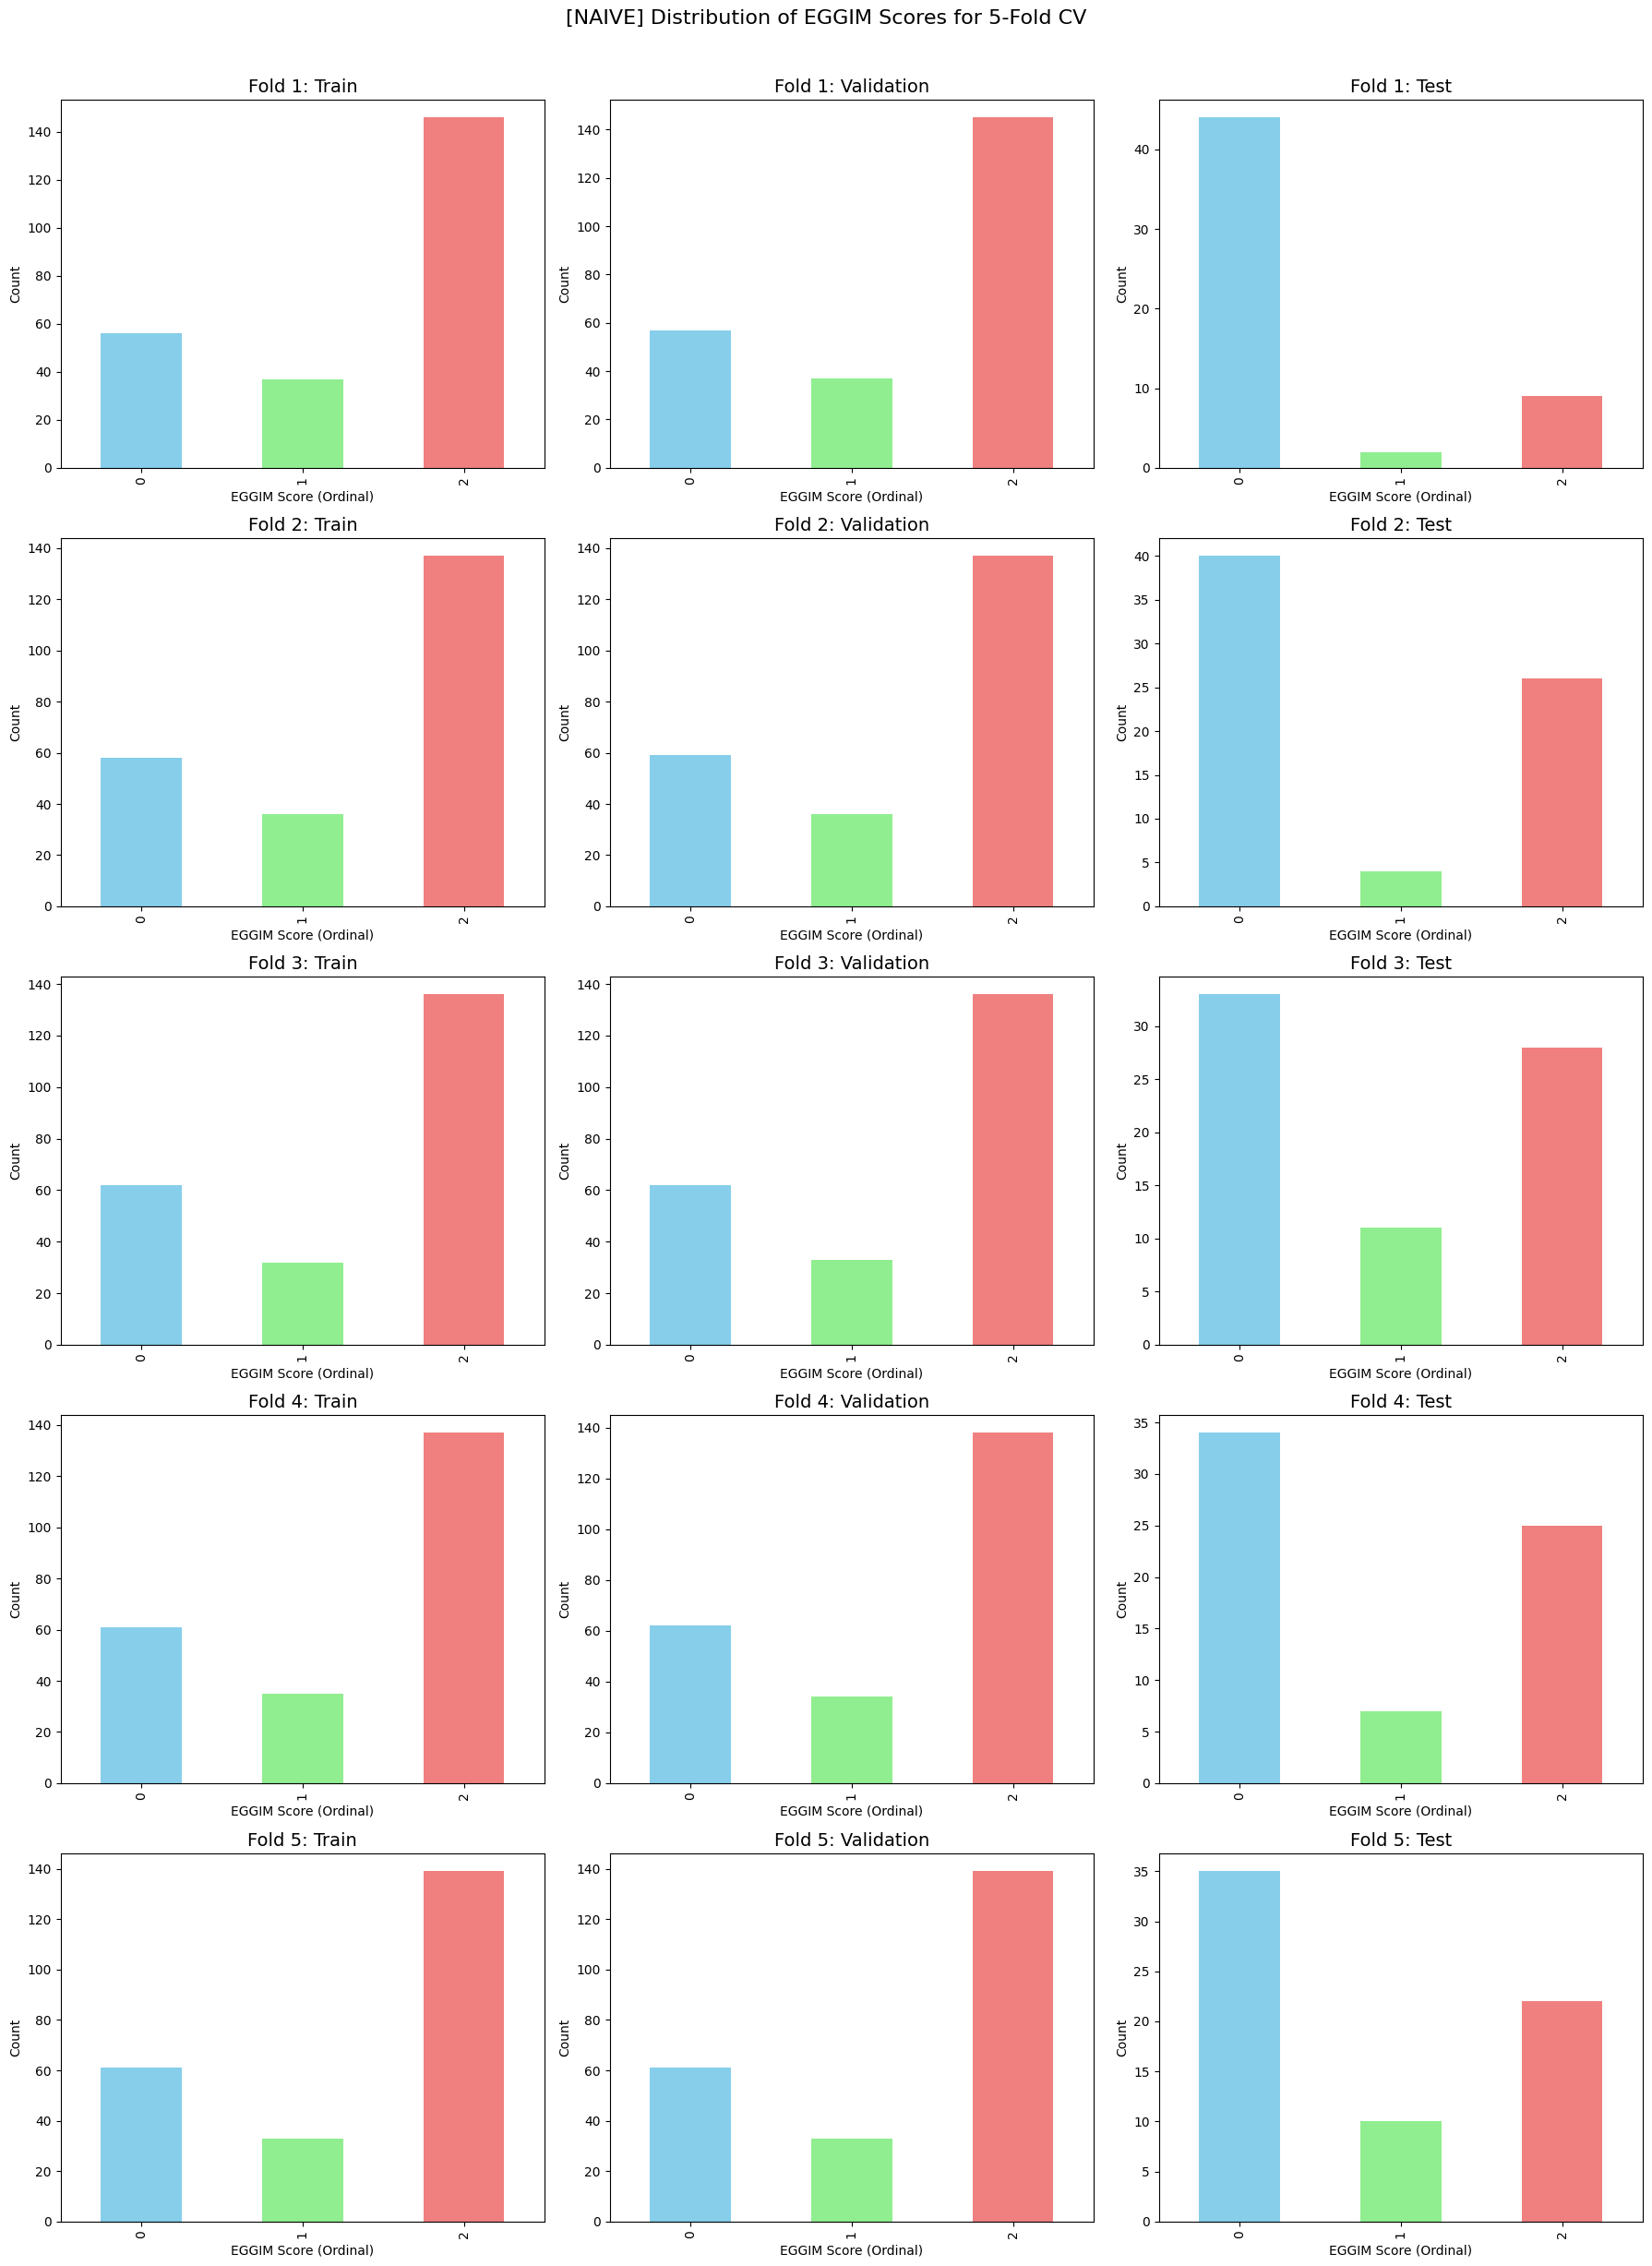

In [32]:
plot_ordinal_distribution_side_by_side_with_colors(naive_splits, 'NAIVE')

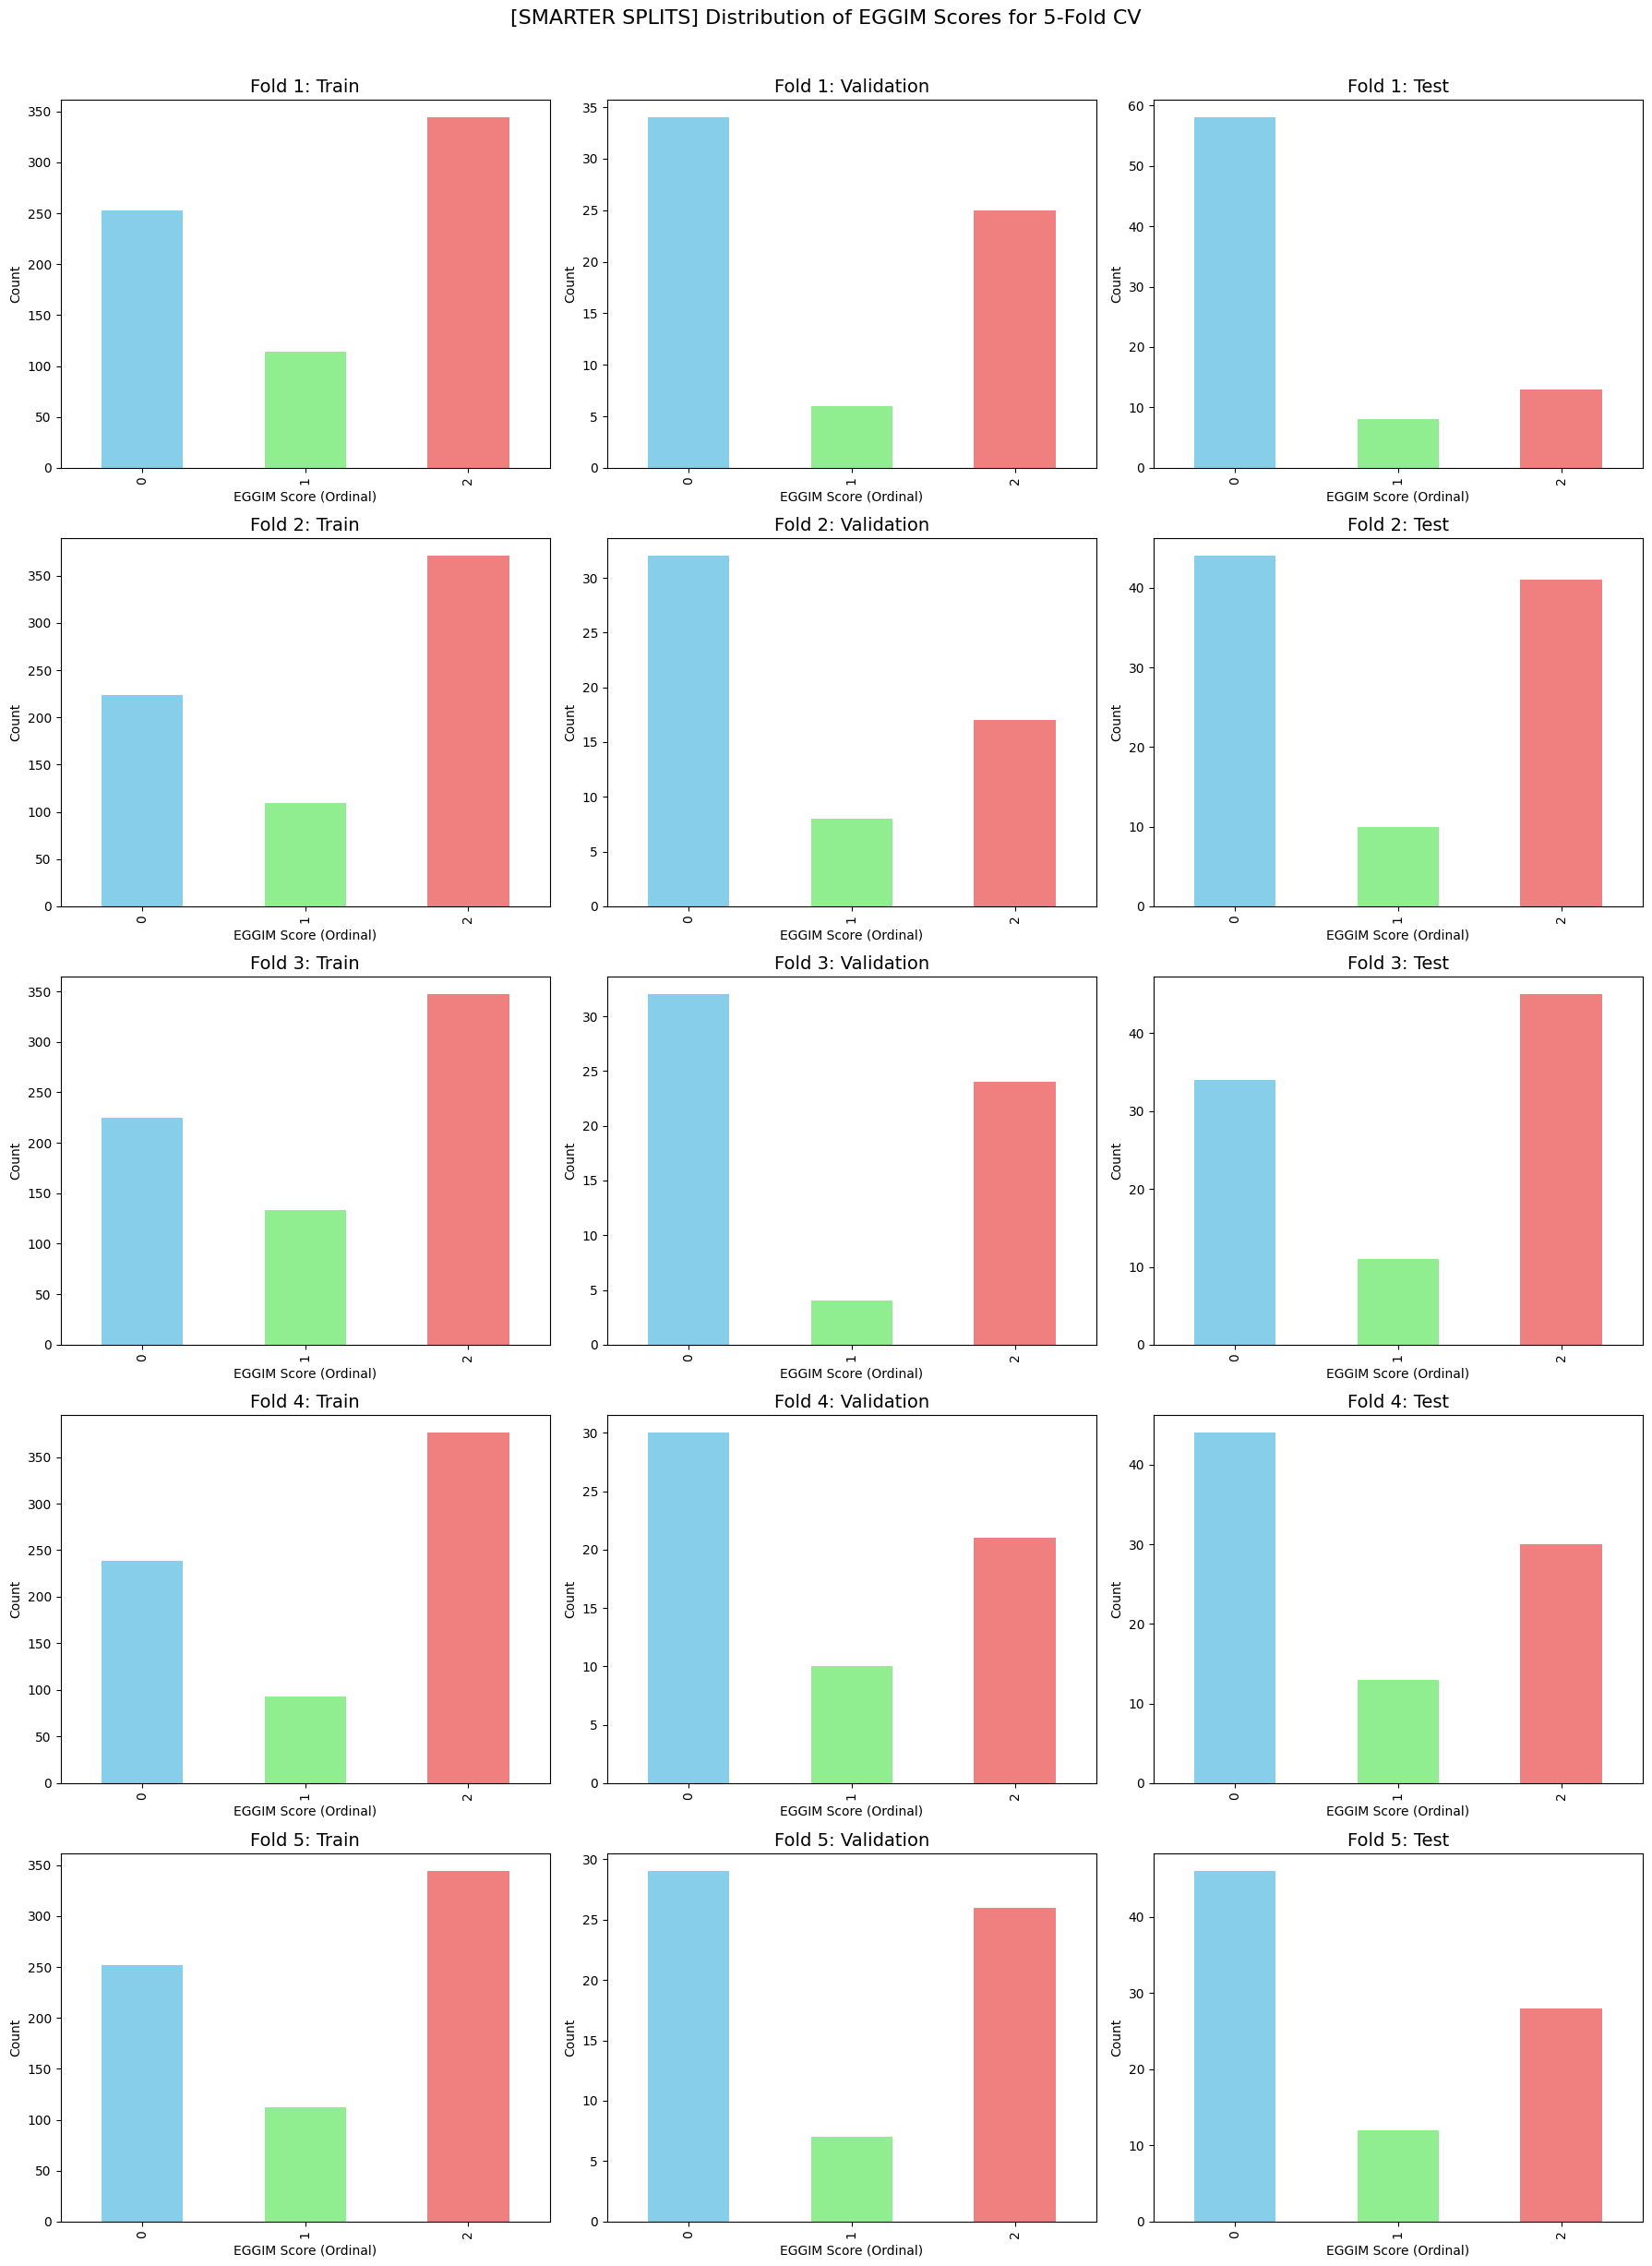

In [33]:
plot_ordinal_distribution_side_by_side_with_colors(smarter_splits, 'SMARTER SPLITS')

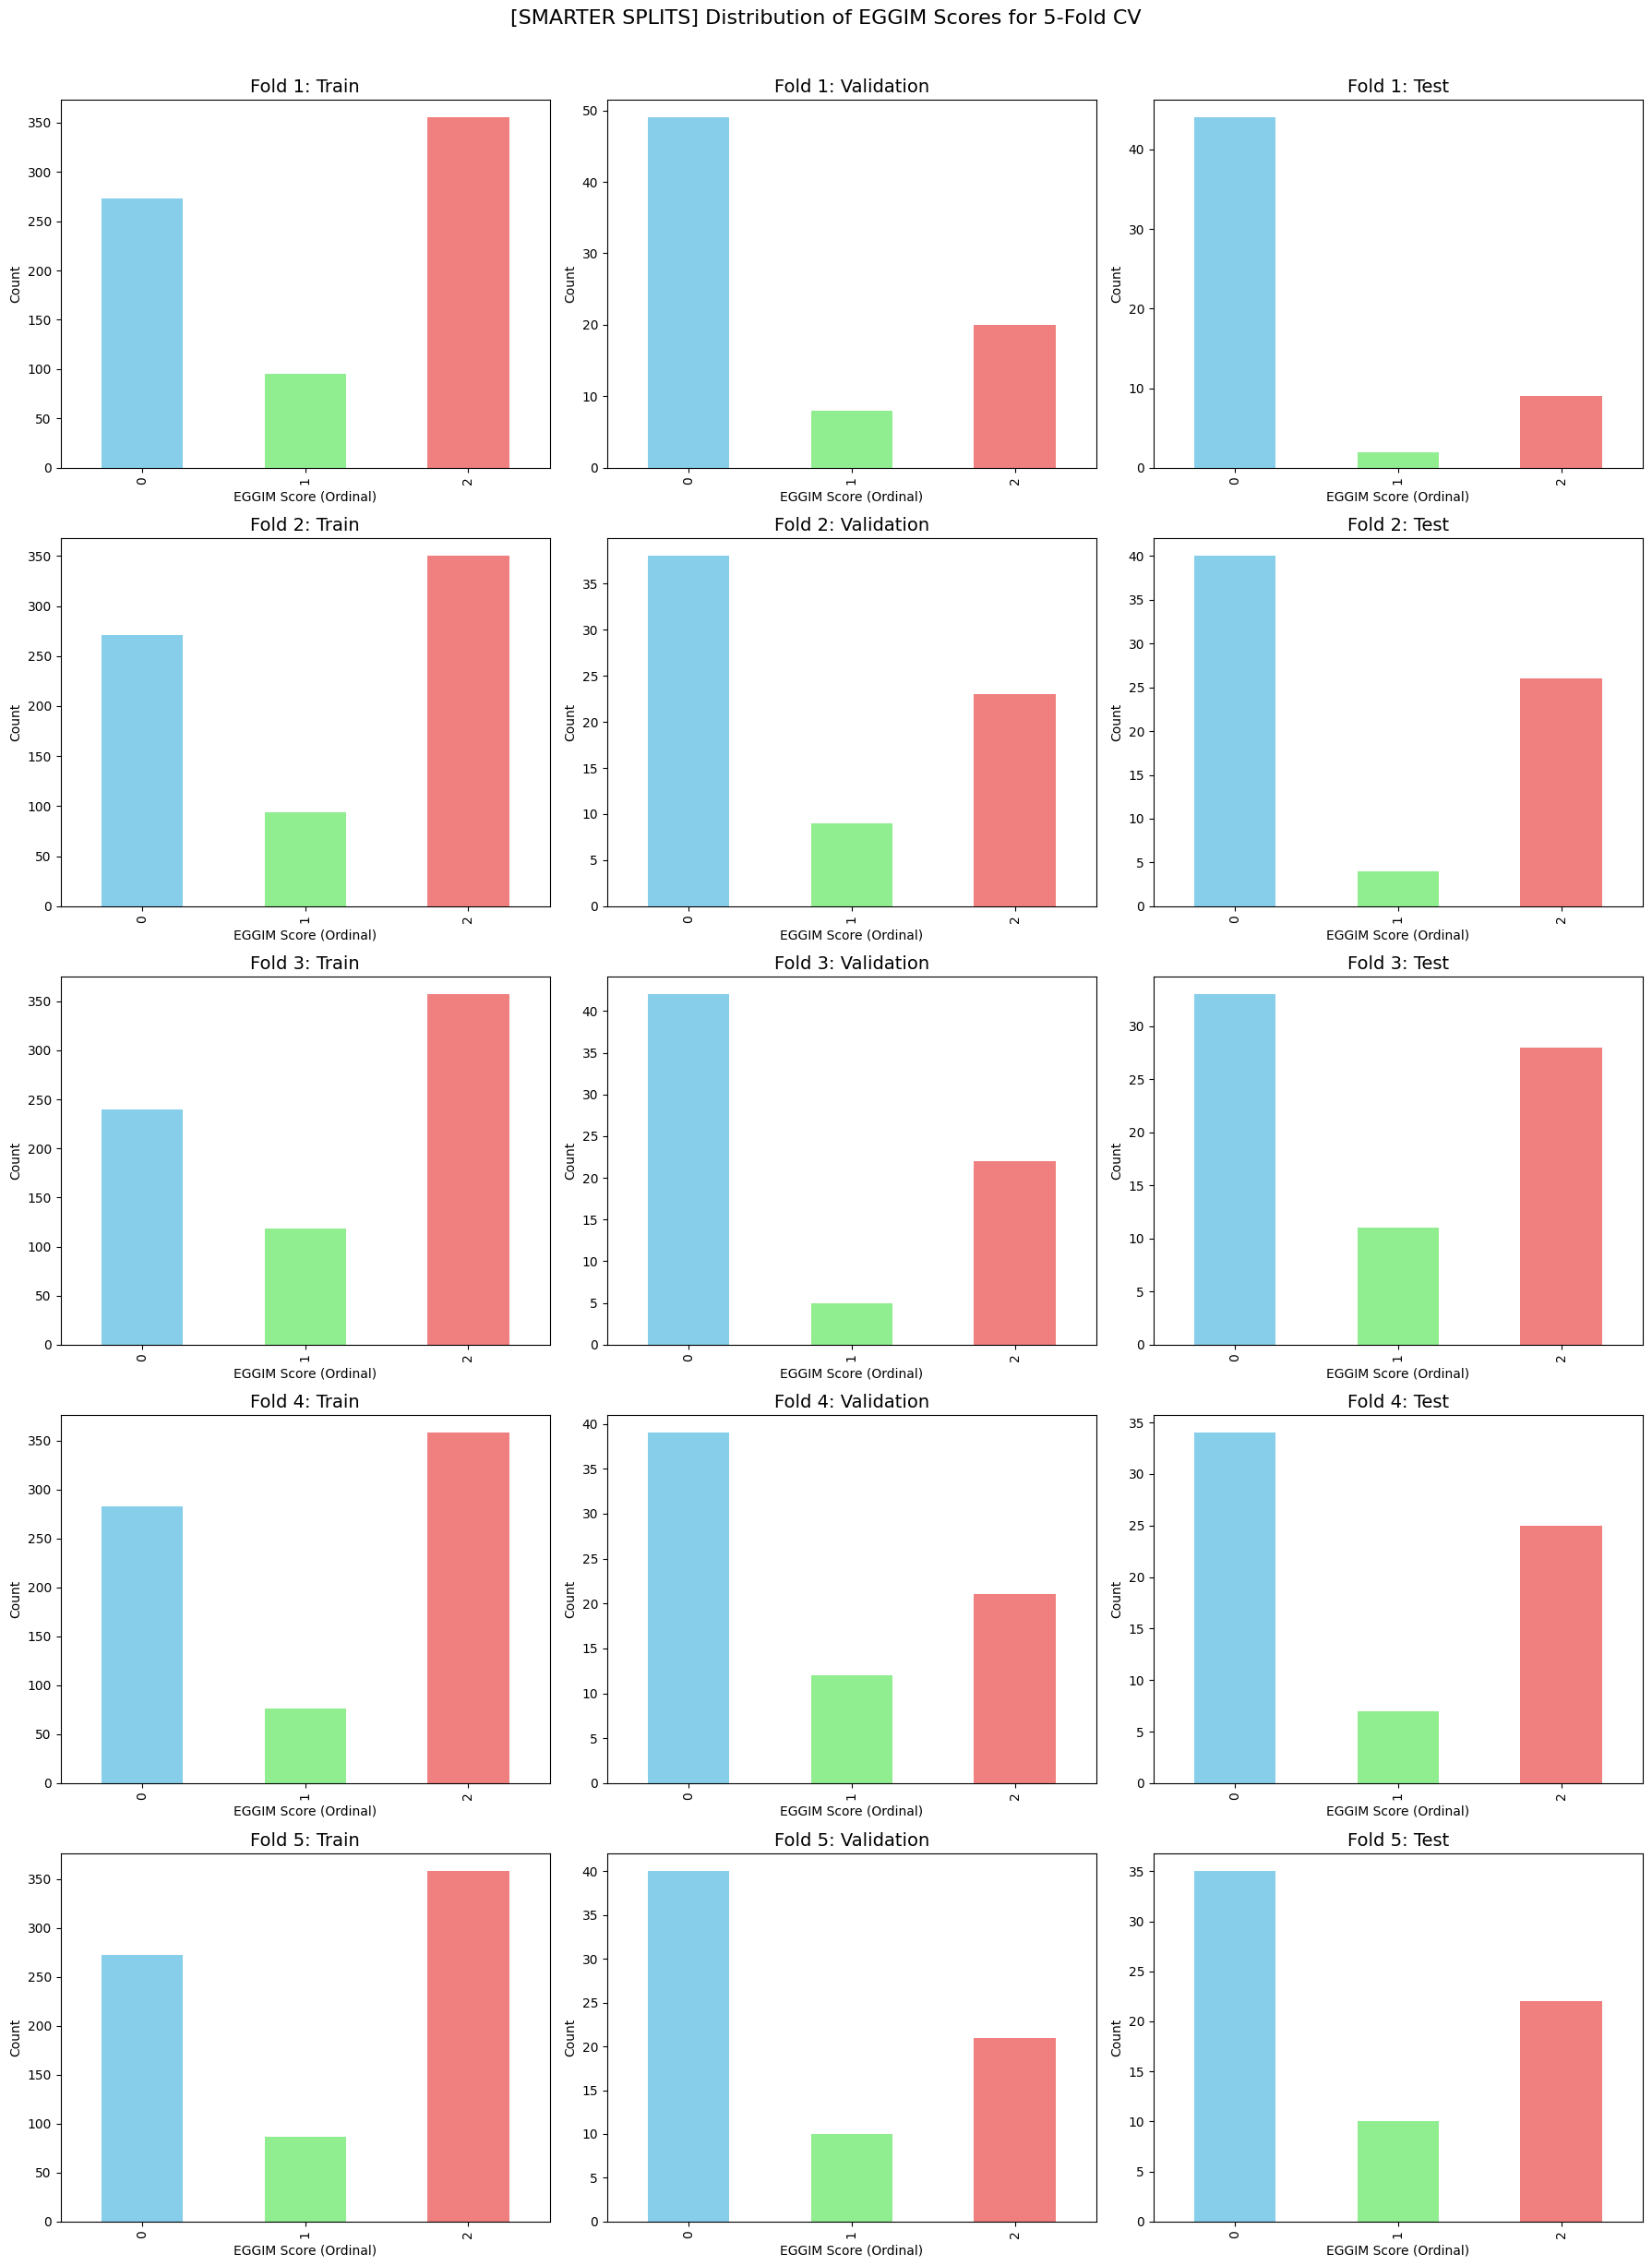

In [36]:
[[list(np.unique(train['patient_id'])), list(np.unique(val['patient_id'])), list(np.unique(val['patient_id']))] for (train, test, val) in togas_only_splits]

[[['PT004',
   'PT005',
   'PT006',
   'PT008',
   'PT009',
   'PT011',
   'PT012',
   'PT014',
   'PT015',
   'PT016',
   'PT018',
   'PT020',
   'PT021',
   'PT022'],
  ['PT002', 'PT003', 'PT007', 'PT010', 'PT013', 'PT017', 'PT019'],
  ['PT002', 'PT003', 'PT007', 'PT010', 'PT013', 'PT017', 'PT019']],
 [['PT002',
   'PT003',
   'PT004',
   'PT005',
   'PT008',
   'PT009',
   'PT011',
   'PT012',
   'PT013',
   'PT014',
   'PT017',
   'PT018',
   'PT019',
   'PT020'],
  ['PT006', 'PT007', 'PT010', 'PT015', 'PT016', 'PT021', 'PT022'],
  ['PT006', 'PT007', 'PT010', 'PT015', 'PT016', 'PT021', 'PT022']],
 [['PT003',
   'PT005',
   'PT006',
   'PT008',
   'PT010',
   'PT011',
   'PT014',
   'PT015',
   'PT016',
   'PT017',
   'PT019',
   'PT020',
   'PT021',
   'PT022'],
  ['PT002', 'PT004', 'PT007', 'PT009', 'PT012', 'PT013', 'PT018'],
  ['PT002', 'PT004', 'PT007', 'PT009', 'PT012', 'PT013', 'PT018']],
 [['PT003',
   'PT005',
   'PT007',
   'PT011',
   'PT013',
   'PT014',
   'PT015',
   '

In [37]:
[np.unique(val['patient_id']) for (train, test, val) in togas_only_splits]

[array(['PT002', 'PT003', 'PT007', 'PT010', 'PT013', 'PT017', 'PT019'],
       dtype=object),
 array(['PT006', 'PT007', 'PT010', 'PT015', 'PT016', 'PT021', 'PT022'],
       dtype=object),
 array(['PT002', 'PT004', 'PT007', 'PT009', 'PT012', 'PT013', 'PT018'],
       dtype=object),
 array(['PT002', 'PT004', 'PT006', 'PT008', 'PT009', 'PT010', 'PT012'],
       dtype=object),
 array(['PT003', 'PT004', 'PT005', 'PT007', 'PT015', 'PT018', 'PT021'],
       dtype=object)]

In [11]:
num_folds = 5
dp = DatasetProcessor(target_dir)
df = dp.process(merge_eggim_square=True)
def replace_landmark_name(landmark):
    new_landmark_name = {'ii': 'distal body',
                    'ix': 'distal lc',
                    'vi': 'proximal ant lc',
                    'vii': 'proximal ant gc/pw',
                    'viii': 'incisura r',
                    'x': 'upper body r',
                    'xii': 'upper body ant'}
    landmark_number = landmark.split('.')[0]
    return new_landmark_name[landmark_number]
df['landmark'] = df['landmark'].apply(replace_landmark_name)
togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)

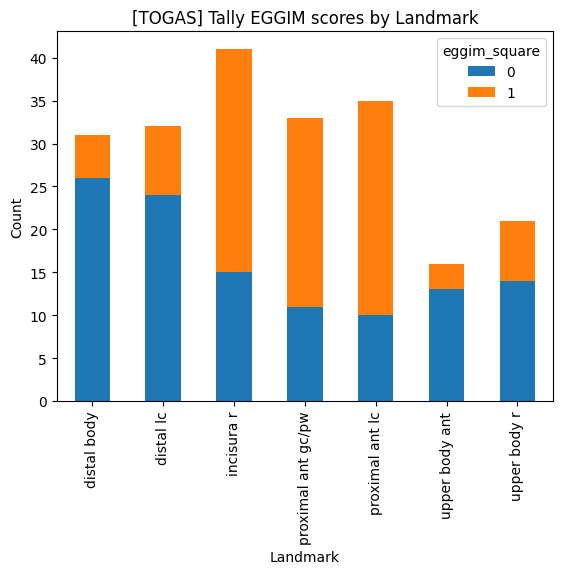

In [12]:
plot_pivot_table(df_togas, 'TOGAS')

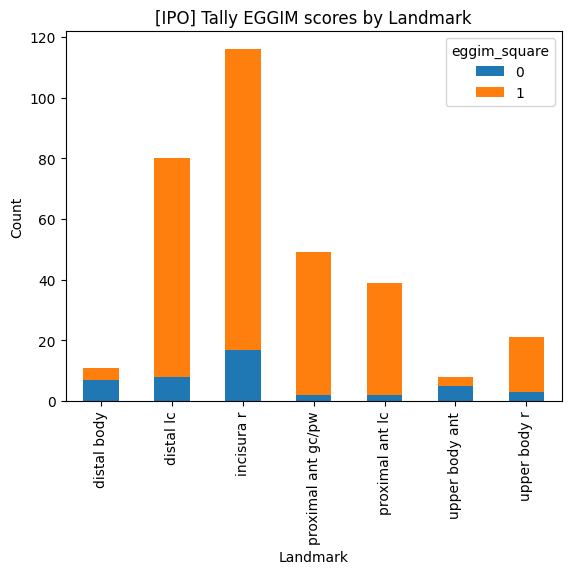

In [14]:
plot_pivot_table(df_ipo, 'IPO')

In [28]:
split_togas_only = dp.single_ds_group_k_splits(df_togas,
                                        k=num_folds,
                                        train_size=0.9,
                                        test_size=0.1,
                                        internal_train_size=0.5,
                                        random_state=42)

split_naive = dp.naive_multiple_ds_group_k_splits(df_togas,
                                      df_ipo,
                                      k=num_folds,
                                      train_size=0.9,
                                      test_size=0.1,
                                      internal_train_size=0.5,
                                      random_state=42)

split_smart = dp.smart_multiple_ds_group_k_splits(df_togas,
                                      df_ipo,
                                      k=num_folds,
                                      train_size=0.9,
                                      test_size=0.1,
                                      internal_train_size=0.5,
                                      random_state=42)
split_smarter = dp.smarter_multiple_ds_group_k_splits(df_togas,
                                      df_ipo,
                                      k=num_folds,
                                      train_size=0.9,
                                      test_size=0.1,
                                      internal_train_size=0.5,
                                      random_state=42)

togas_only_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_togas_only]
naive_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_naive]
smart_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_smart]
smarter_splits = [[df_train, df_val, df_test] for (df_train, df_val, df_test) in split_smarter]

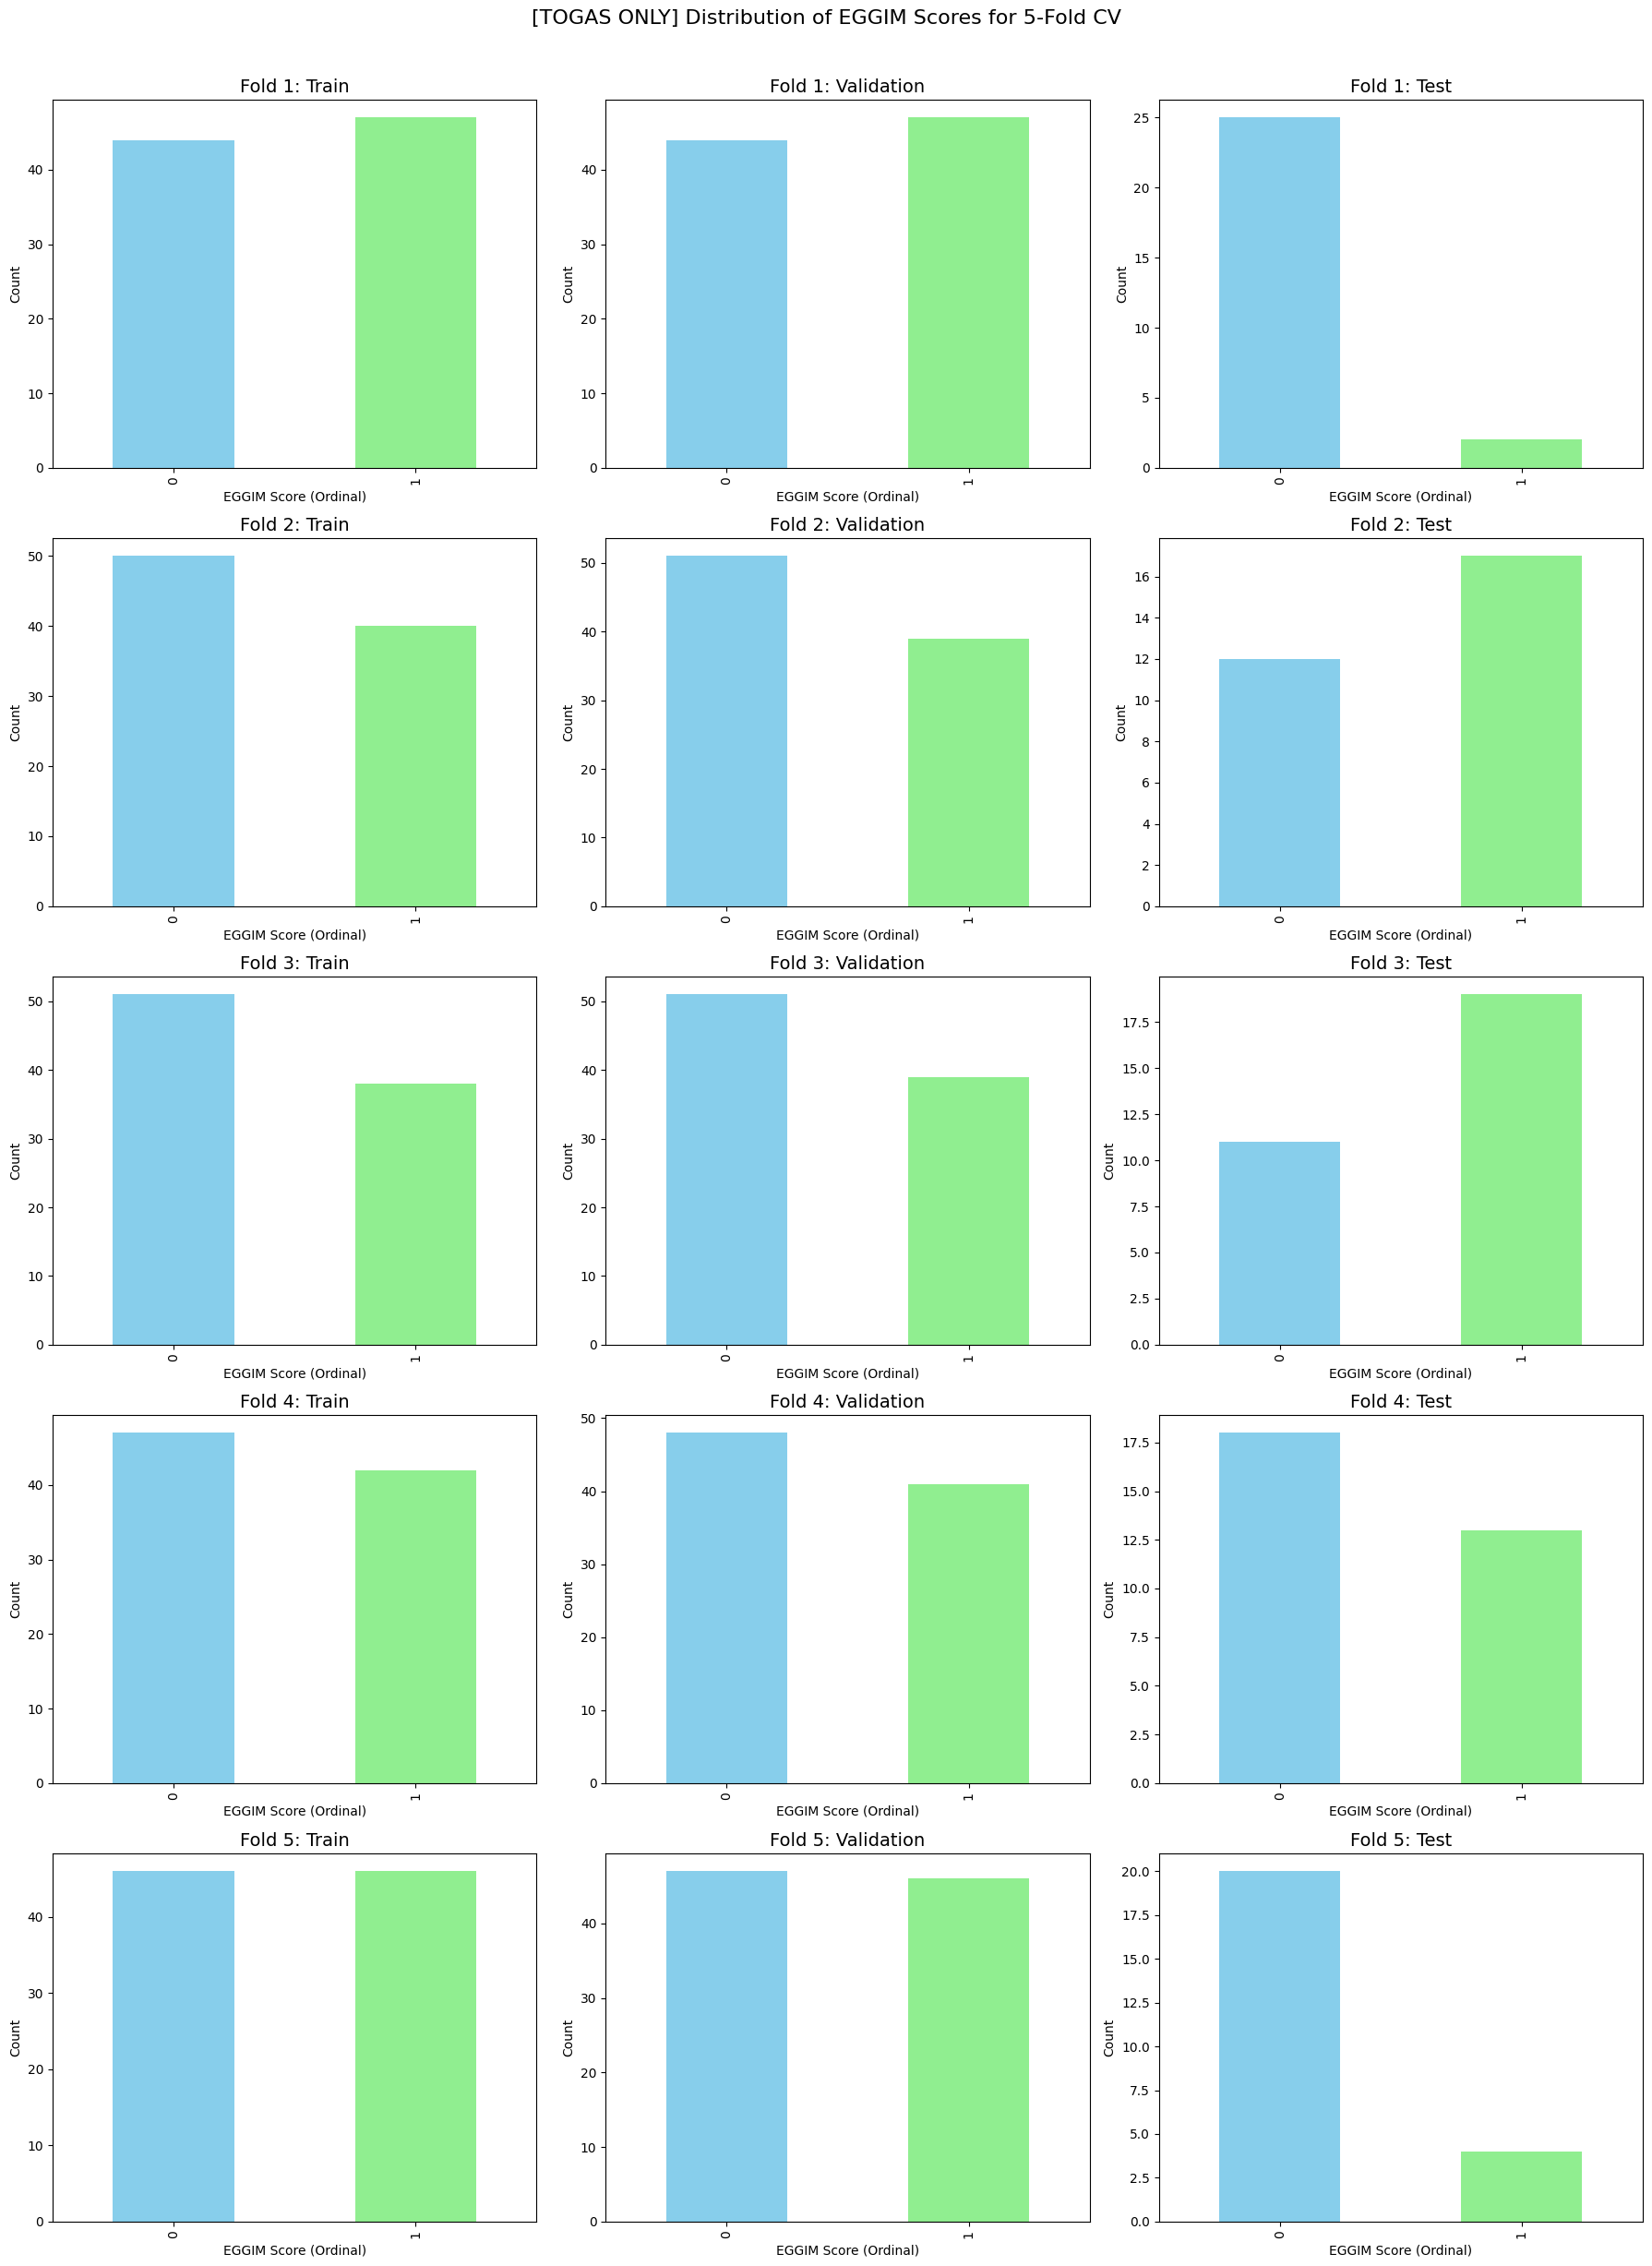

In [29]:
plot_ordinal_distribution_side_by_side_with_colors(togas_only_splits, 'TOGAS ONLY')

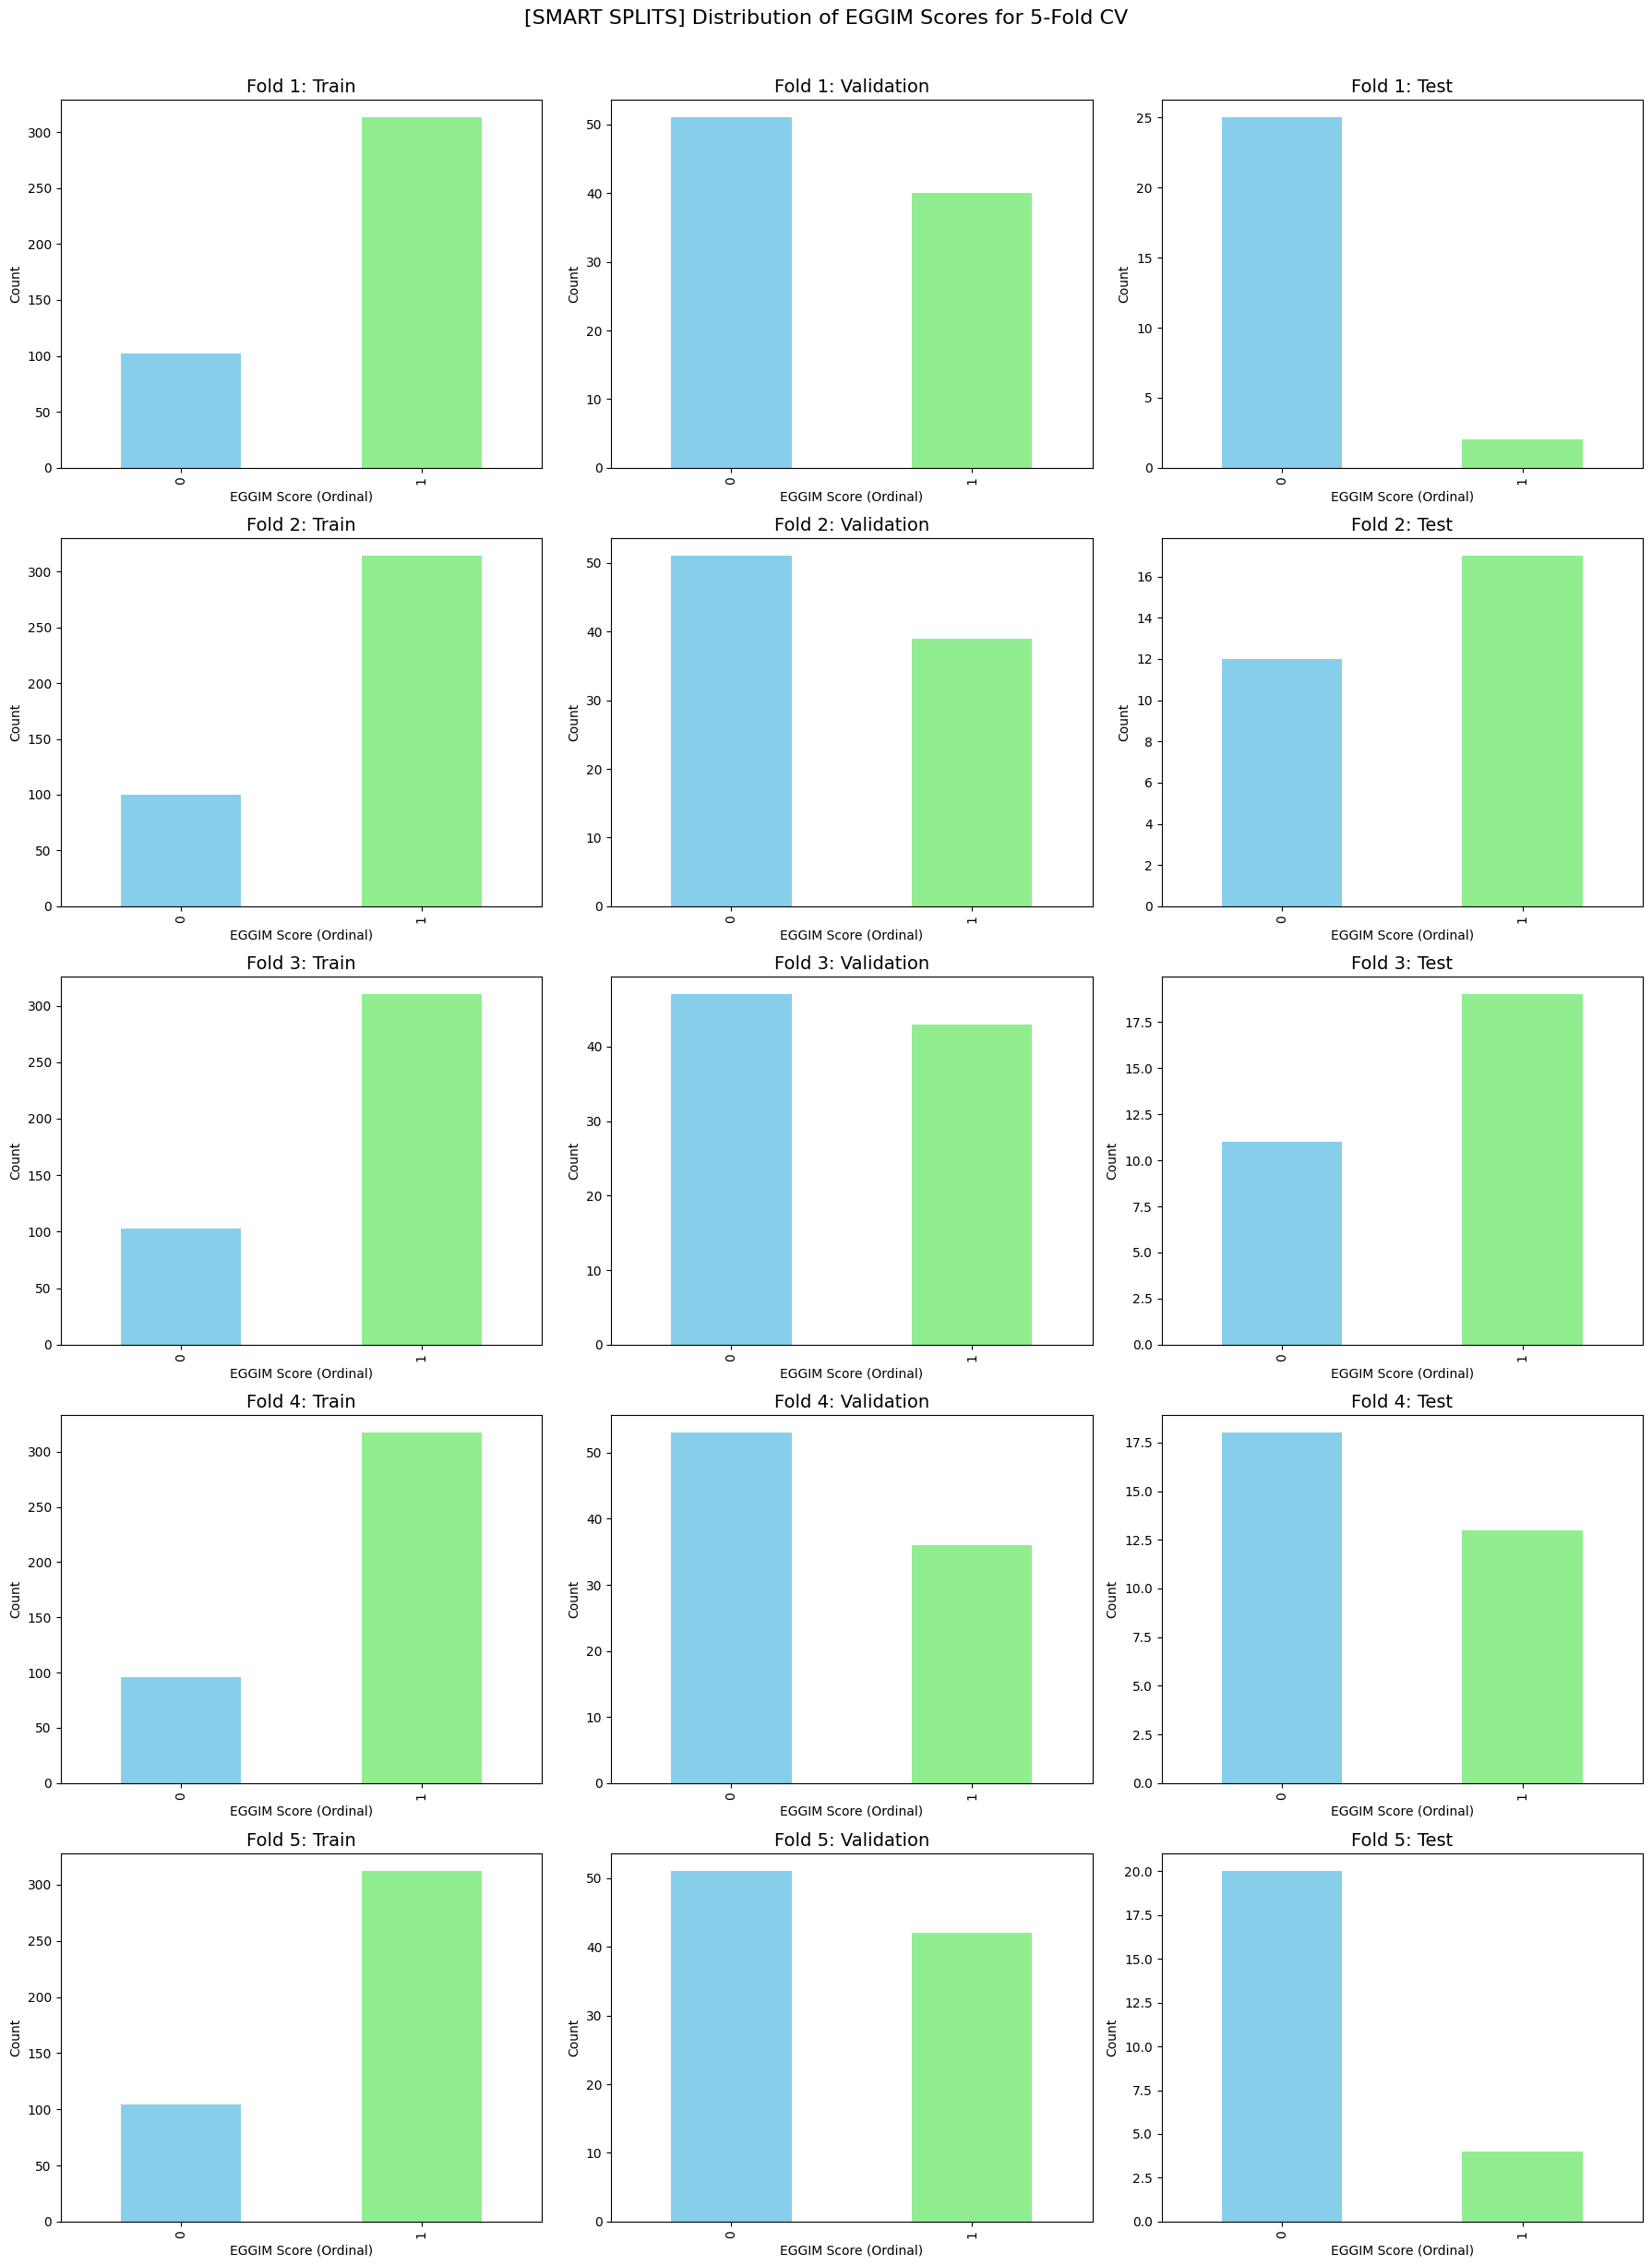

In [30]:
plot_ordinal_distribution_side_by_side_with_colors(smart_splits, 'SMART SPLITS')

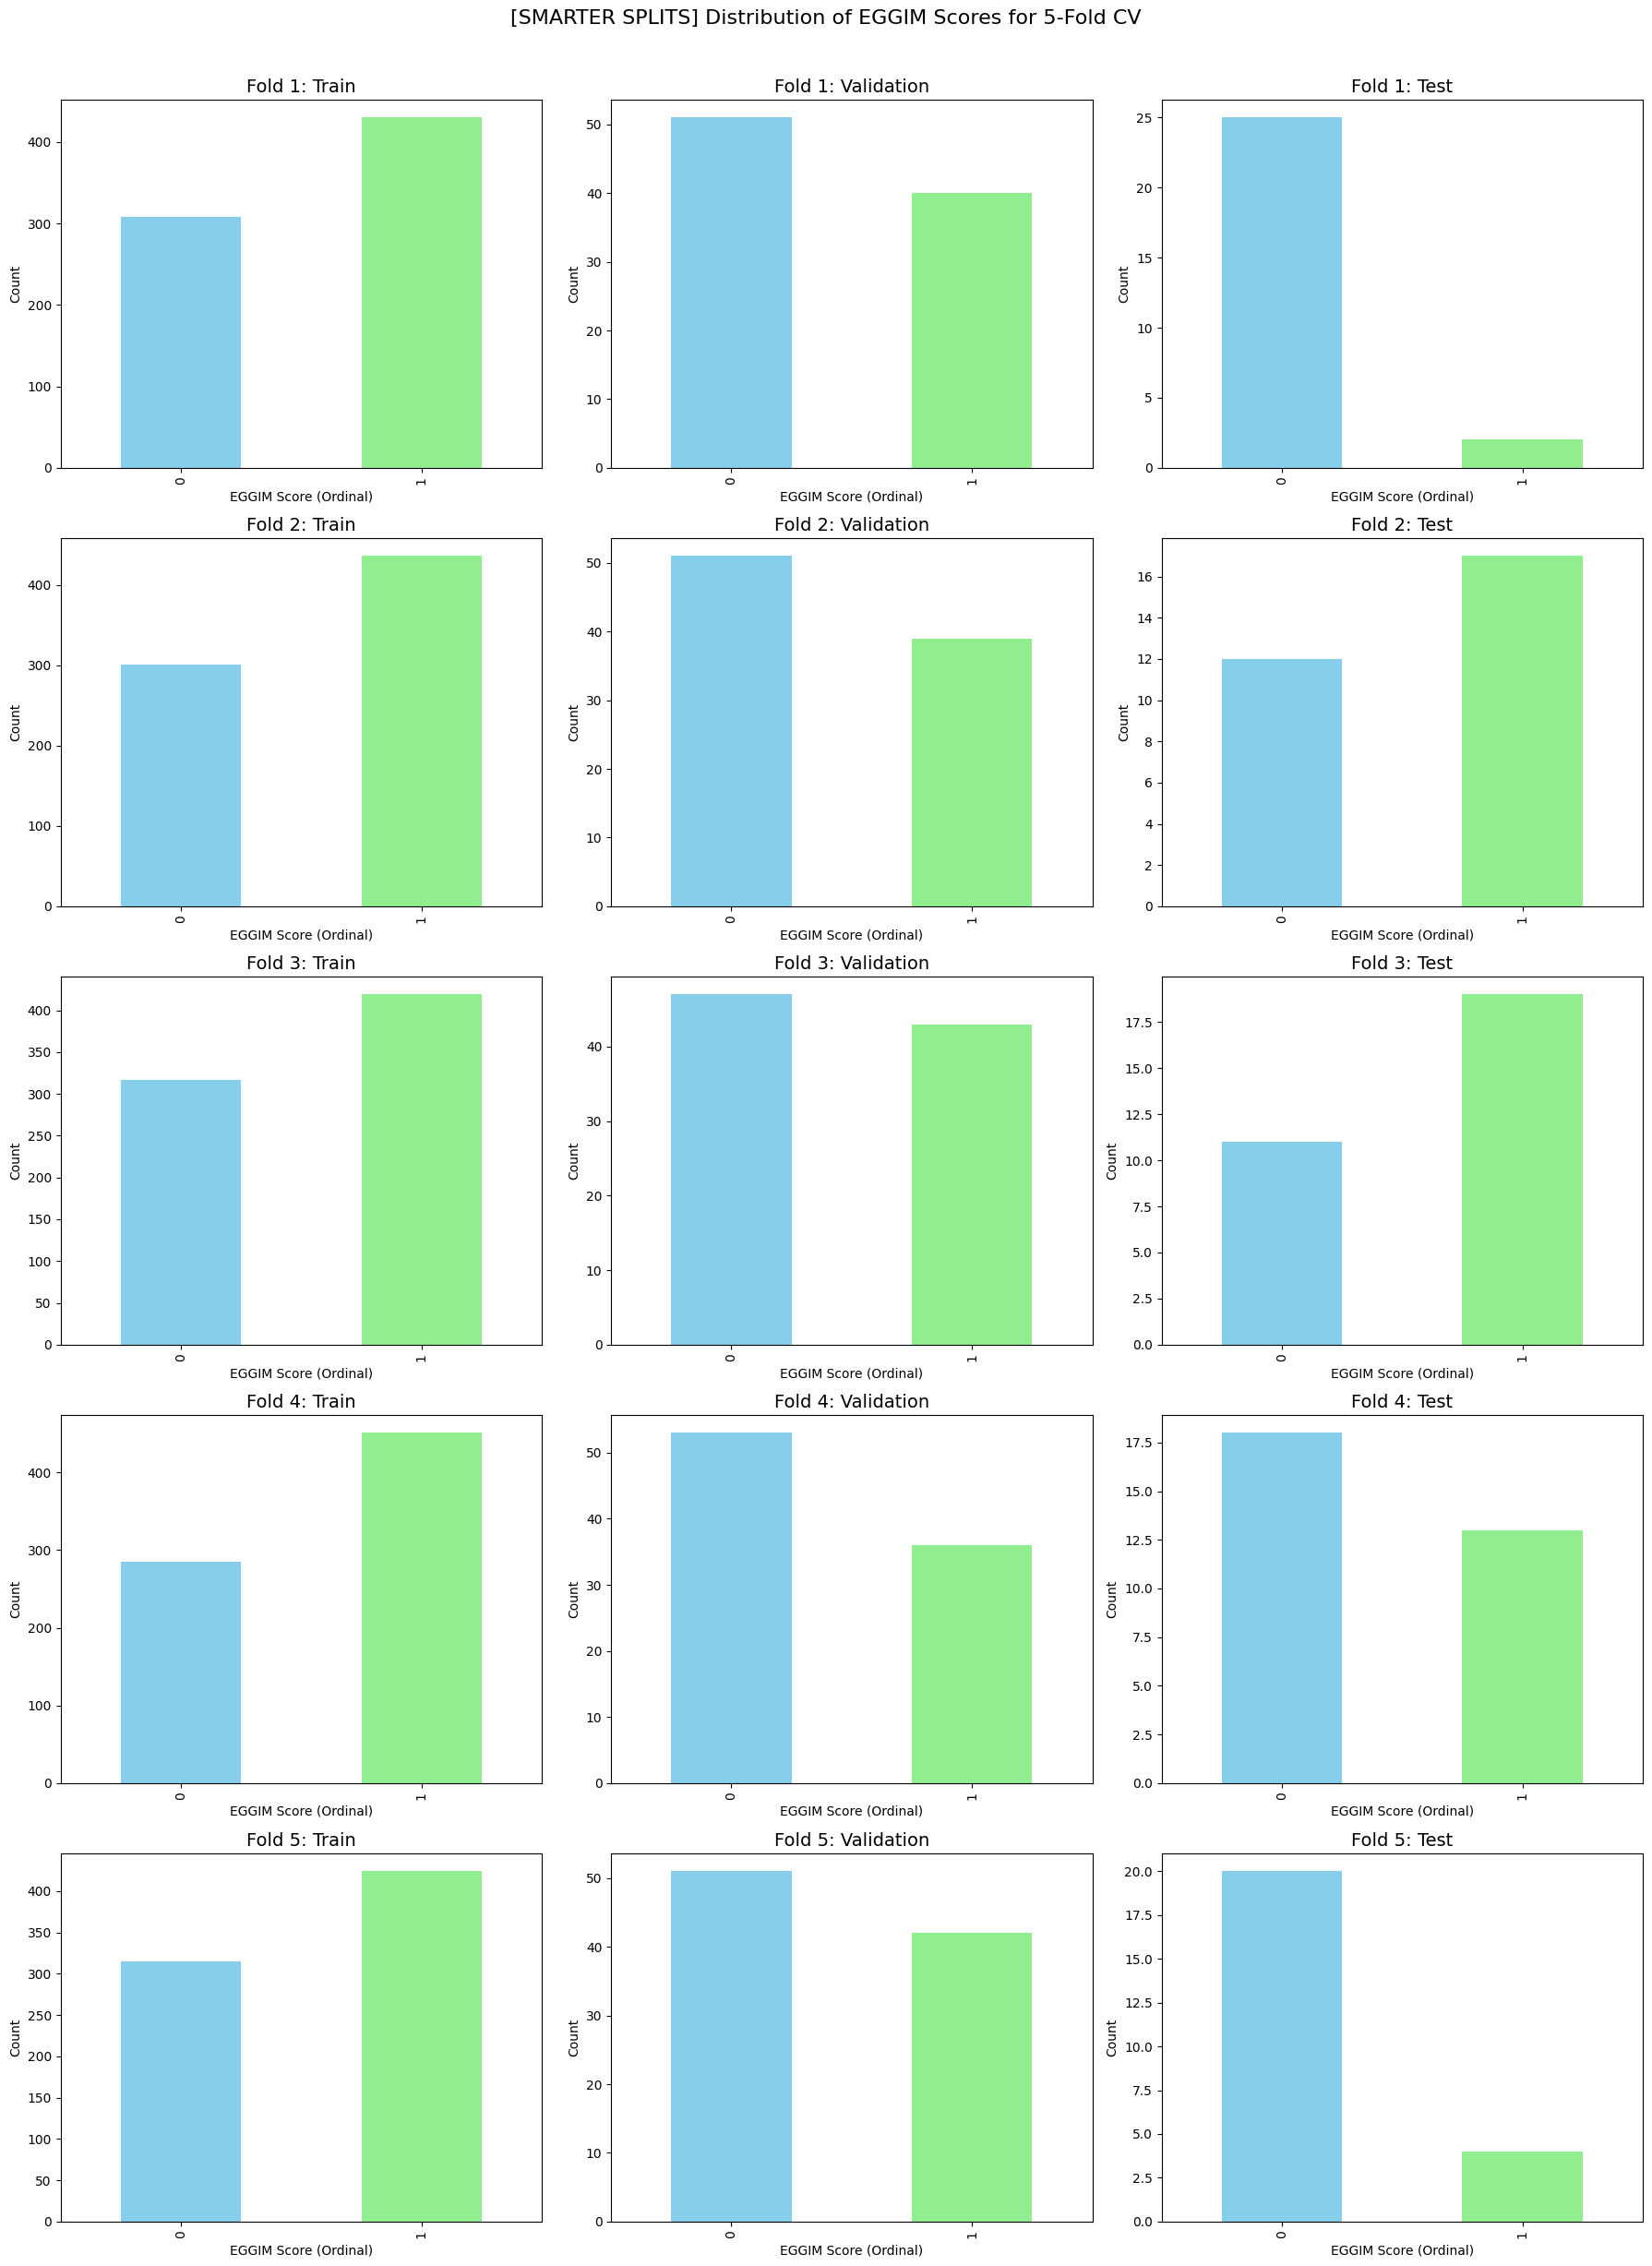

In [31]:
plot_ordinal_distribution_side_by_side_with_colors(smarter_splits, 'SMARTER SPLITS')

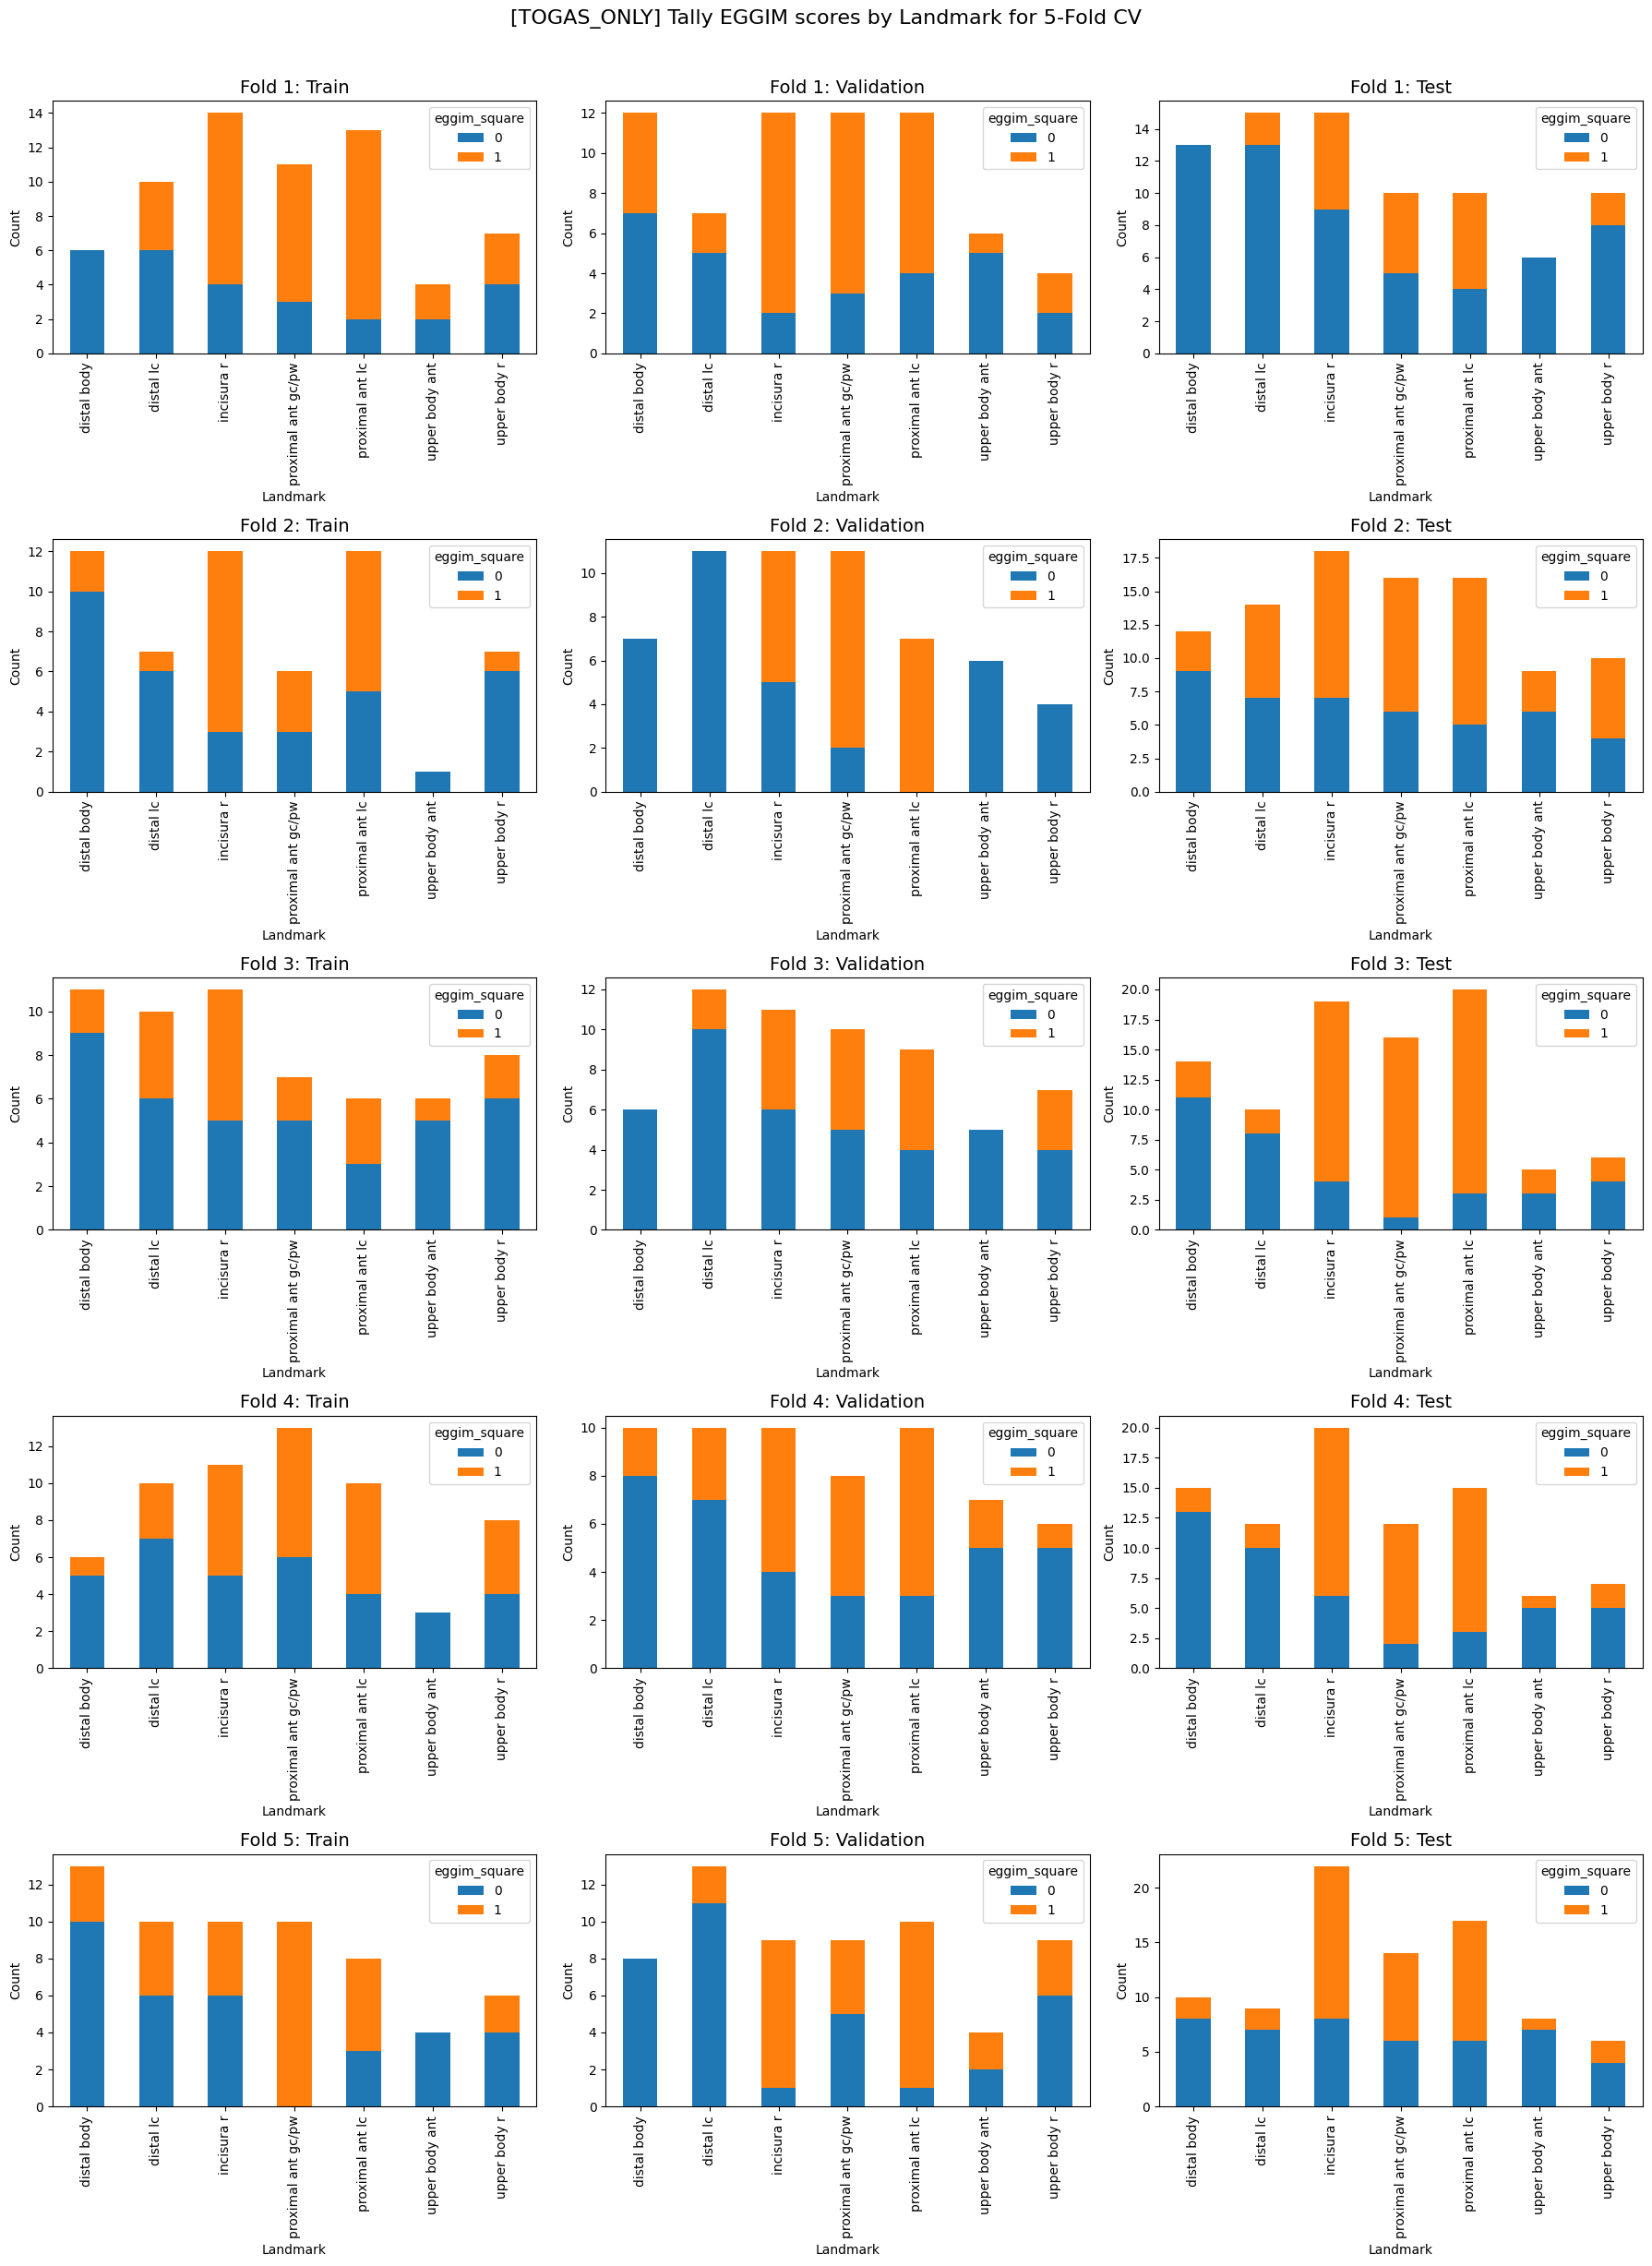

In [24]:
plot_pivot_table_side_by_side(togas_only_splits, 'TOGAS_ONLY')

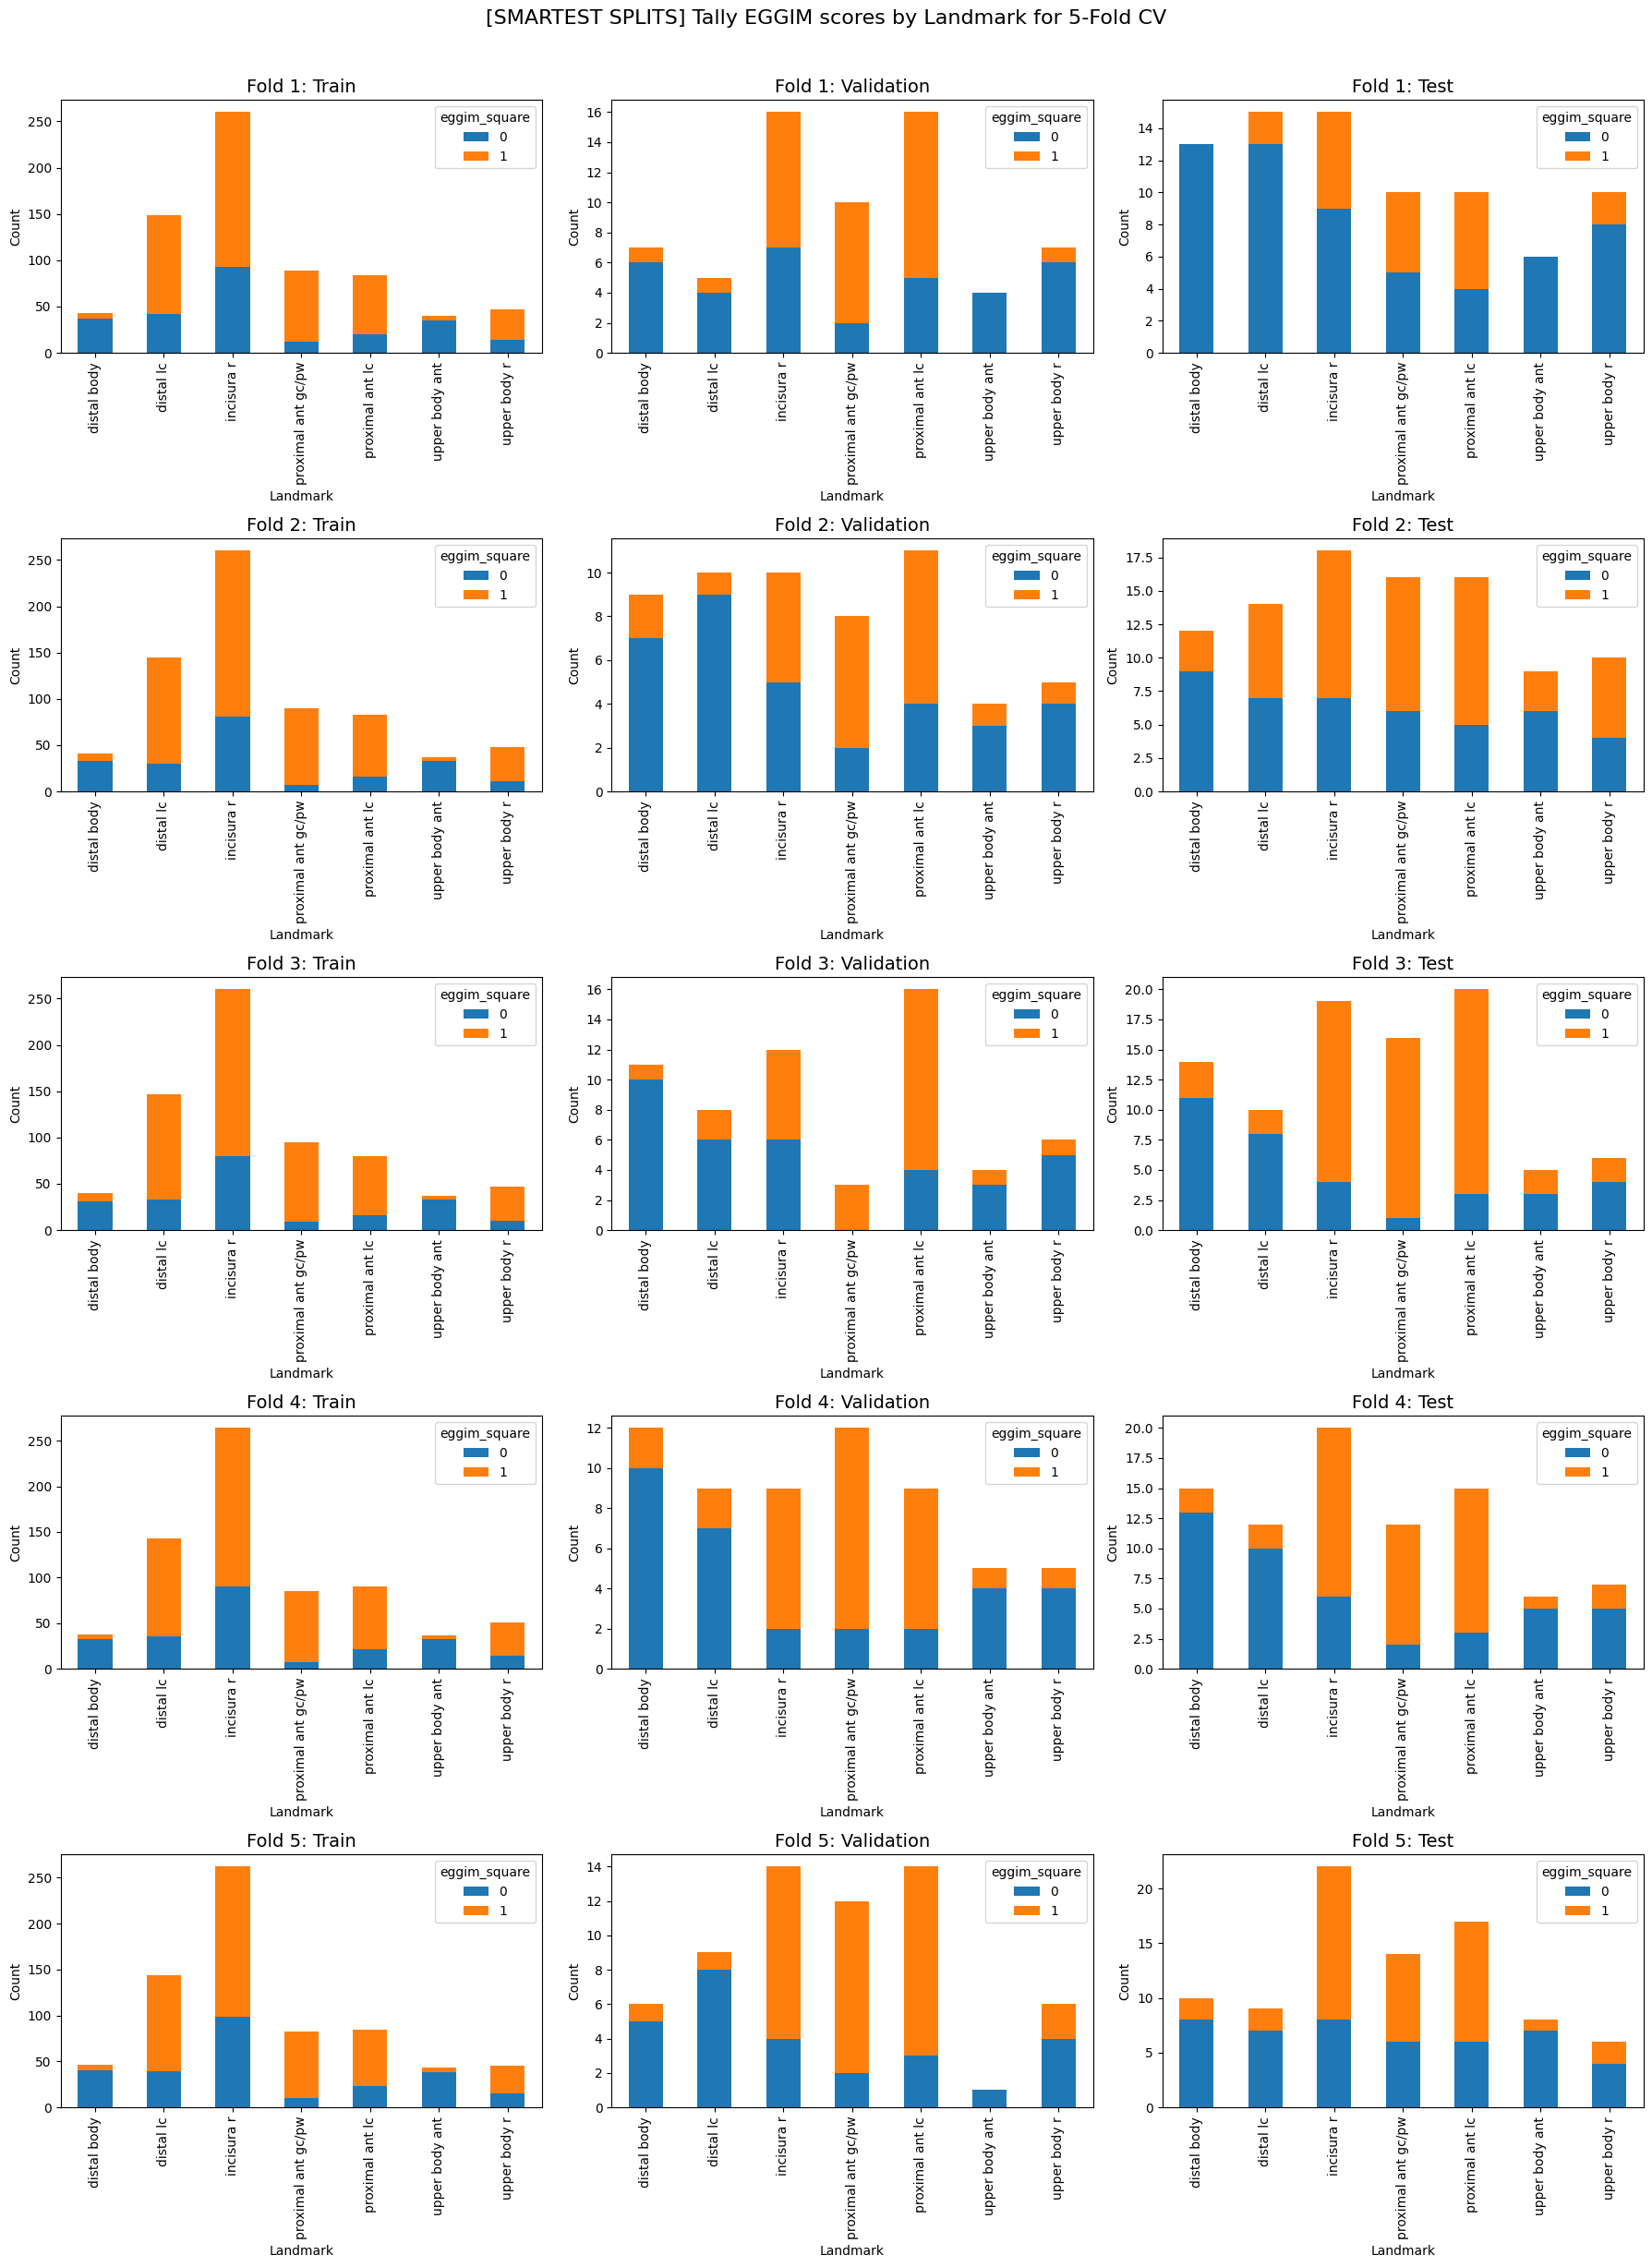

In [23]:
plot_pivot_table_side_by_side(smartest_splits, 'SMARTEST SPLITS')